In [1]:
###############################################################################
# The Institute for the Design of Advanced Energy Systems Integrated Platform
# Framework (IDAES IP) was produced under the DOE Institute for the
# Design of Advanced Energy Systems (IDAES).
#
# Copyright (c) 2018-2025 by the software owners: The Regents of the
# University of California, through Lawrence Berkeley National Laboratory,
# National Technology & Engineering Solutions of Sandia, LLC, Carnegie Mellon
# University, West Virginia University Research Corporation, et al.
# All rights reserved.  Please see the files COPYRIGHT.md and LICENSE.md
# for full copyright and license information.
#
###############################################################################

# Autothermal Reformer Flowsheet Optimization with OMLT (TensorFlow Keras) Surrogate Object
Maintainer: Brandon Paul  
Author: Brandon Paul  
Updated: 2023-06-01  
## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the OMLT package utilizing TensorFlow Keras neural networks. In this notebook, sampled simulation data will be used to train and validate a surrogate model. IDAES surrogate plotting tools will be utilized to visualize the surrogates on training and validation data. Once validated, integration of the surrogate into an IDAES flowsheet will be demonstrated.

# 2. Problem Statement 

Within the context of a larger NGFC system, the autothermal reformer generates syngas from air, steam and natural gas for use in a solid-oxide fuel cell (SOFC).

## 2.1. Main Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

## 2.2. Main Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

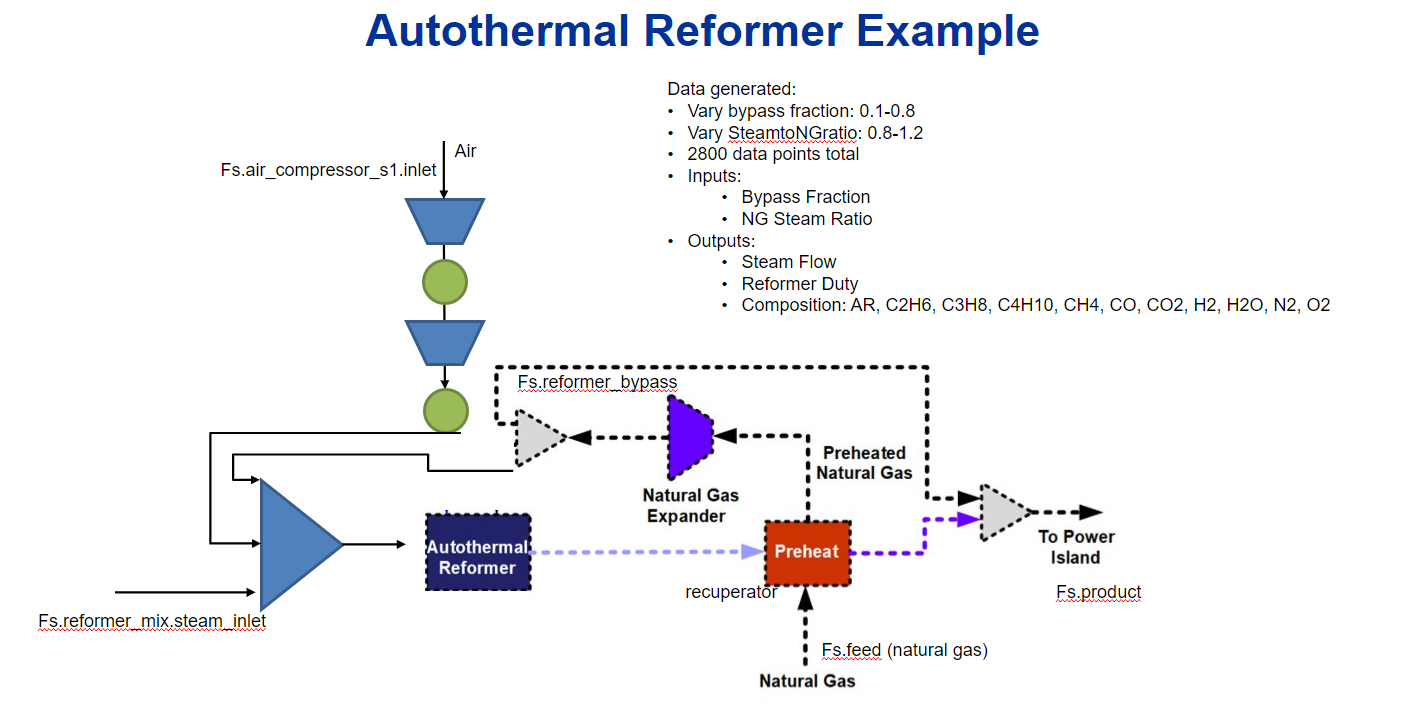

In [2]:
from IPython.display import Image
from pathlib import Path


def datafile_path(name):
    return Path("..") / name


Image(datafile_path("AR_PFD.png"))

## 3. Training and Validating Surrogates

First, let's import the required Python, Pyomo and IDAES modules:

In [3]:
# Import statements
import os
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf

# Import Pyomo libraries
from pyomo.environ import (
    ConcreteModel,
    SolverFactory,
    value,
    Var,
    Constraint,
    Set,
    Objective,
    maximize,
)
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.sampling.scaling import OffsetScaler
from idaes.core.surrogate.keras_surrogate import (
    KerasSurrogate,
    save_keras_json_hd5,
    load_keras_json_hd5,
)
from idaes.core.surrogate.plotting.sm_plotter import (
    surrogate_scatter2D,
    surrogate_parity,
    surrogate_residual,
)
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock

# fix environment variables to ensure consist neural network training
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
np.random.seed(46)
rn.seed(1342)
tf.random.set_seed(62)

2025-03-17 17:36:17.904242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 17:36:17.904968: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:36:17.908041: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 17:36:17.914657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742258177.926239  296211 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742258177.92

## 3.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 2800 data points were simulated from a rigorous IDAES NGFC flowsheet using a grid sampling method. For simplicity and to reduce training runtime, this example randomly selects 100 data points to use for training/validation. The data is separated using an 80/20 split into training and validation data using the IDAES `split_training_validation()` method.

In [4]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(datafile_path("reformer-data.csv"))  # 2800 data points
data = csv_data.sample(n=100)  # randomly sample points for training/validation

input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:]

# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(
    data, 0.8, seed=n_data
)  # seed=100

/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## 3.2 Training Surrogates with TensorFlow Keras

TensorFlow Keras provides an interface to pass regression settings, build neural networks and train surrogate models. Keras enables the usage of two API formats: Sequential and Functional. While the Functional API offers more versatility, including multiple input and output layers in a single neural network, the Sequential API is more stable and user-friendly. Further, the Sequential API integrates cleanly with existing IDAES surrogate tools and will be utilized in this example.

In the code below, we build the neural network structure based on our training data structure and desired regression settings. Offline, neural network models were trained for the list of settings below, and the options bolded and italicized were determined to have the minimum mean squared error for the dataset:

- Activation function: relu, sigmoid, ***tanh***
- Optimizer: ***Adam***, RMSprop, SGD
- Number of hidden layers: 1, ***2***, 4
- Number of neurons per layer: 10, 20, ***40***

Typically, Sequential Keras models are built vertically; the dataset is scaled and normalized. The network is defined for the input layer, hidden layers, and output layer for the passed activation functions and network/layer sizes. Then, the model is compiled using the passed optimizer and trained using a desired number of epochs. Keras internally validates while training and updates each epoch's model weight (coefficient) values.

Finally, after training the model, we save the results and model expressions to a folder that contains a serialized JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [5]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys

stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# selected settings for regression (best fit from options above)
activation, optimizer, n_hidden_layers, n_nodes_per_layer = "tanh", "Adam", 2, 40
loss, metrics = "mse", ["mae", "mse"]

# Create data objects for training using scalar normalization
n_inputs = len(input_labels)
n_outputs = len(output_labels)
x = input_data
y = output_data

input_scaler = None
output_scaler = None
input_scaler = OffsetScaler.create_normalizing_scaler(x)
output_scaler = OffsetScaler.create_normalizing_scaler(y)
x = input_scaler.scale(x)
y = output_scaler.scale(y)
x = x.to_numpy()
y = y.to_numpy()

# Create Keras Sequential object and build neural network
model = tf.keras.Sequential()
model.add(
    tf.keras.layers.Dense(
        units=n_nodes_per_layer, input_dim=n_inputs, activation=activation
    )
)
for i in range(1, n_hidden_layers):
    model.add(tf.keras.layers.Dense(units=n_nodes_per_layer, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

# Train surrogate (calls optimizer on neural network and solves for weights)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    ".mdl_wts.keras", save_best_only=True, monitor="val_loss", mode="min"
)
history = model.fit(
    x=x, y=y, validation_split=0.2, verbose=1, epochs=1000, callbacks=[mcp_save]
)

# save model to JSON and create callable surrogate object
xmin, xmax = [0.1, 0.8], [0.8, 1.2]
input_bounds = {input_labels[i]: (xmin[i], xmax[i]) for i in range(len(input_labels))}

keras_surrogate = KerasSurrogate(
    model,
    input_labels=list(input_labels),
    output_labels=list(output_labels),
    input_bounds=input_bounds,
    input_scaler=input_scaler,
    output_scaler=output_scaler,
)
keras_surrogate.save_to_folder(
    keras_folder_name="keras_surrogate", keras_model_name="keras_model"
)

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split("\n")
for line in celloutput[:50]:
    print(line)
print(".")
print(".")
print(".")
for line in celloutput[-50:]:
    print(line)

/home/dang/miniforge3/envs/idaes_examples_py3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-17 17:36:20.210719: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.3746 - mae: 0.5232 - mse: 0.3746 - val_loss: 0.3230 - val_mae: 0.4945 - val_mse: 0.3230
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3106 - mae: 0.4715 - mse: 0.3106 - val_loss: 0.2687 - val_mae: 0.4451 - val_mse: 0.2687
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2580 - mae: 0.4245 - mse: 0.2580 - val_loss: 0.2238 - val_mae: 0.3994 - val_mse: 0.2238
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2151 - mae: 0.3820 - mse: 0.2151 - val_loss: 0.1868 - val_mae: 0.3573 - val_mse: 0.1868
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1801 - mae: 0.3442 - mse: 0.1801 - val_loss: 0.1562 - val_mae: 0.3199 - val_mse: 0.1562
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1519 - mae: 0.3108 - mse: 0.1519 - val_loss: 0.1310 - val_mae: 0.2865 - val_mse: 0.1310
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1291 - mae: 0.2831 - mse: 0.1291 - val_loss:

## 3.3 Visualizing surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity, and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates fit the data. Then the validation data will be visualized to confirm the surrogates accurately predict new output values.

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


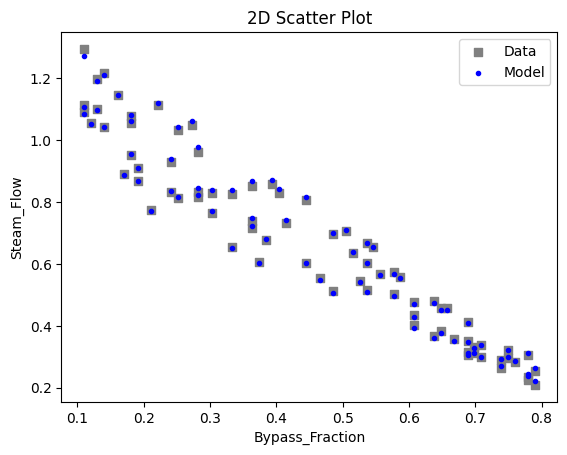

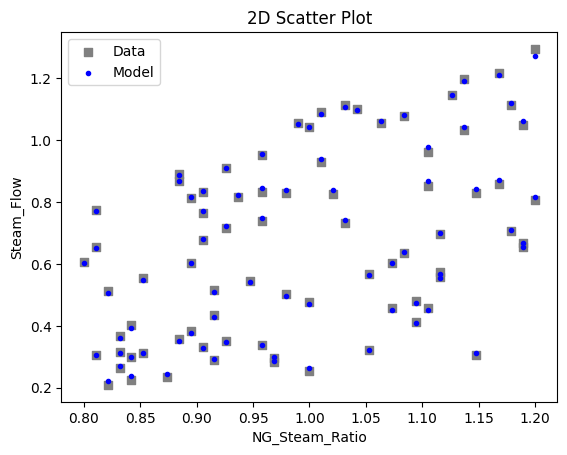

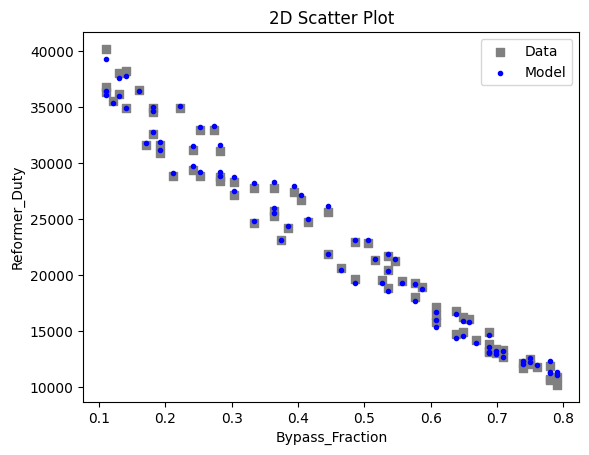

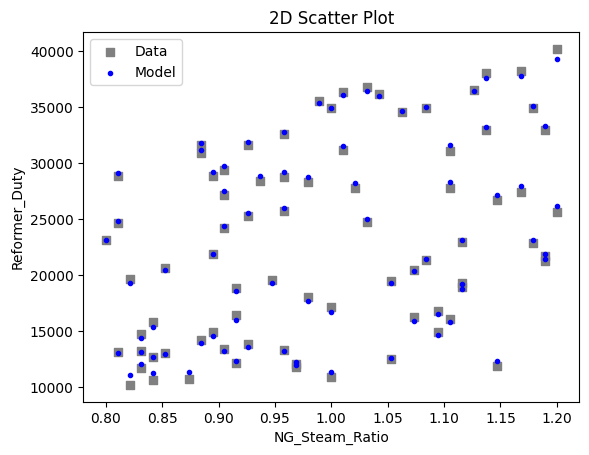

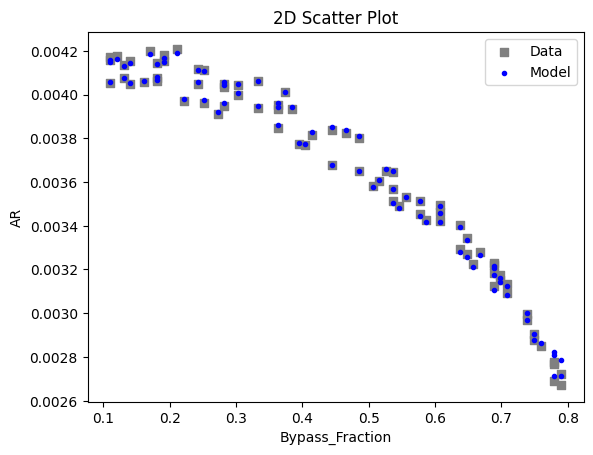

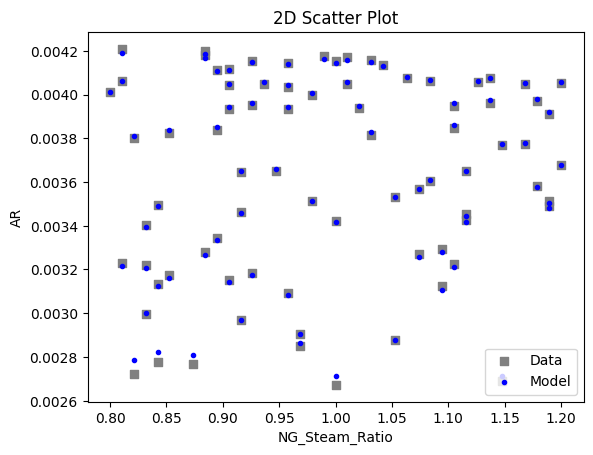

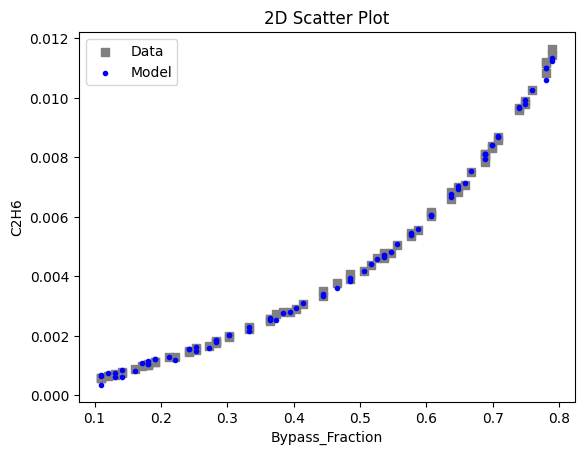

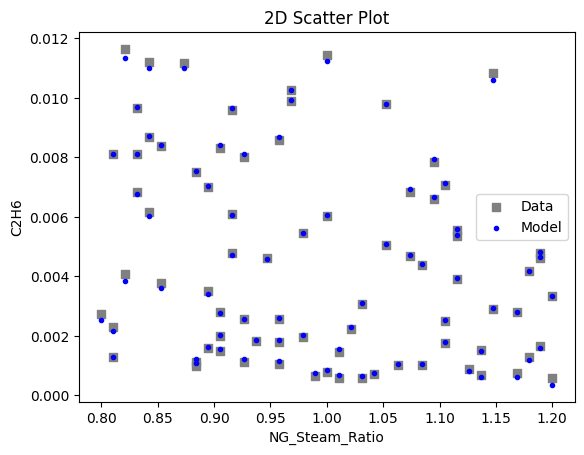

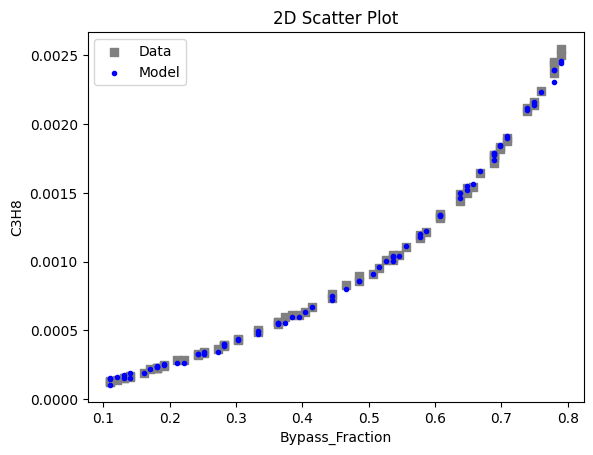

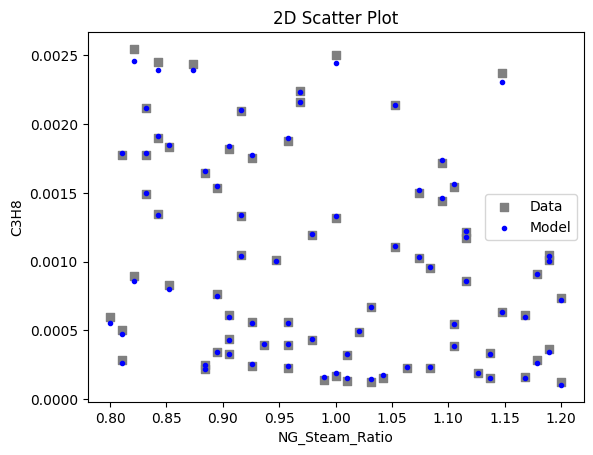

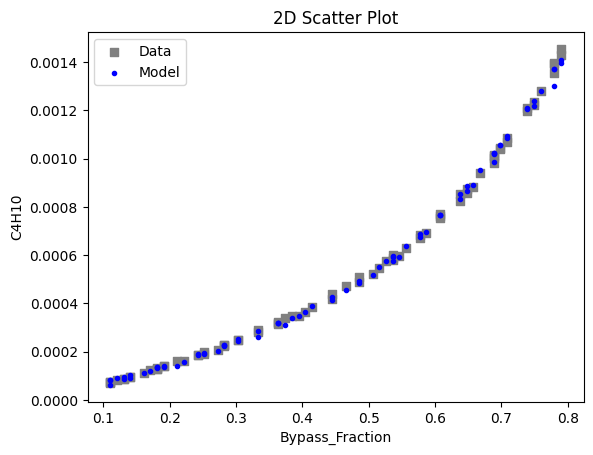

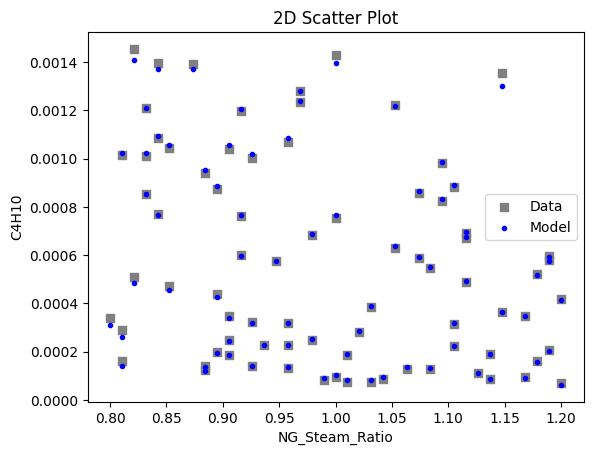

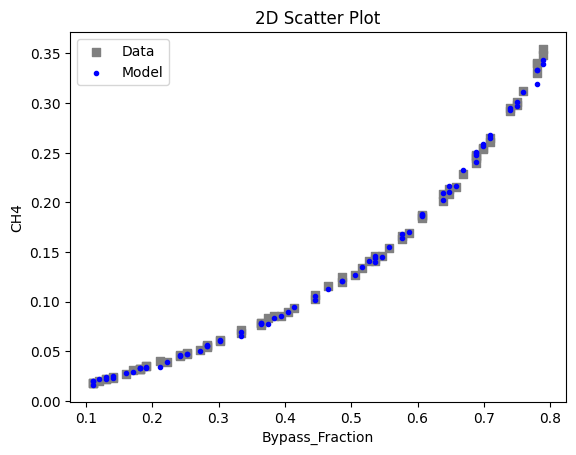

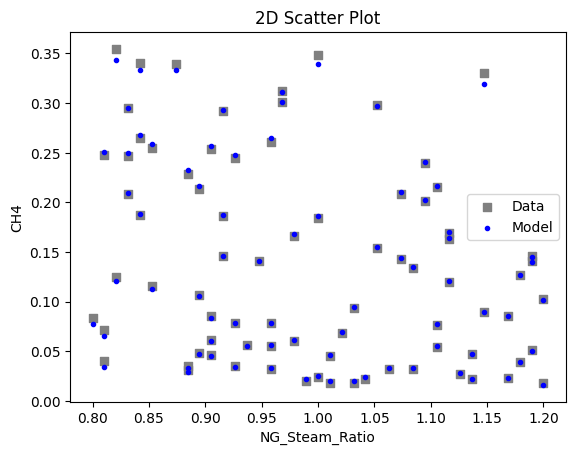

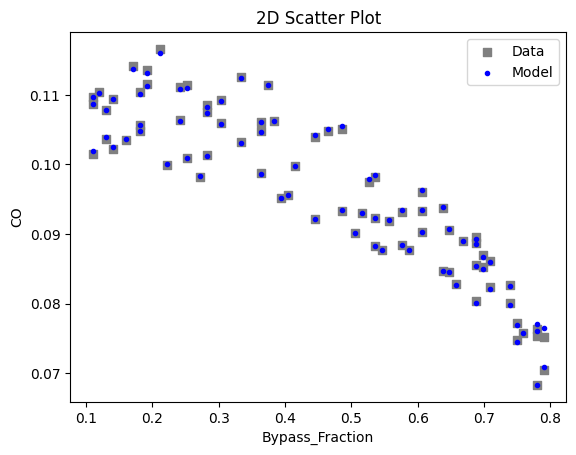

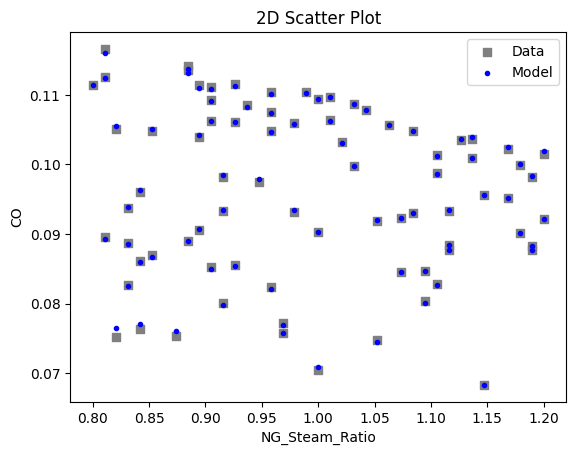

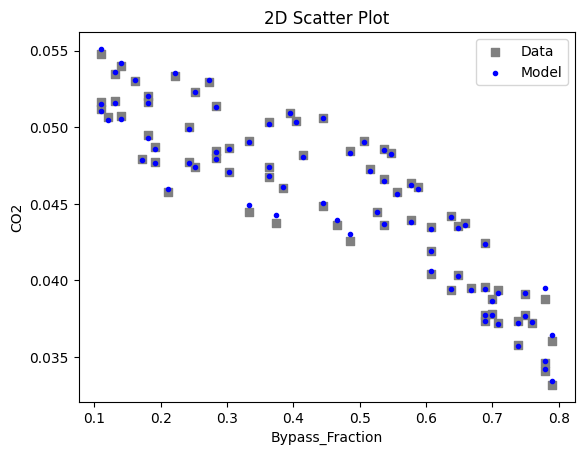

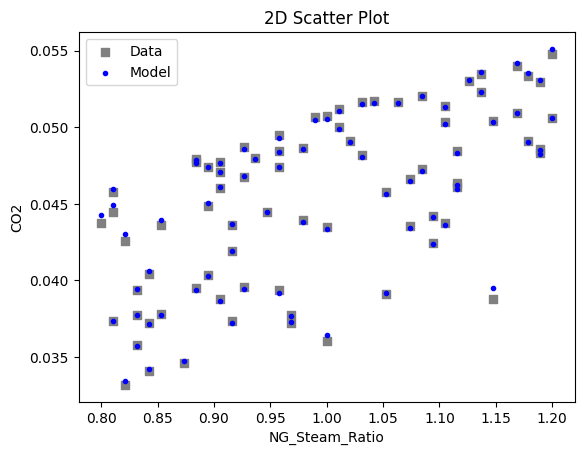

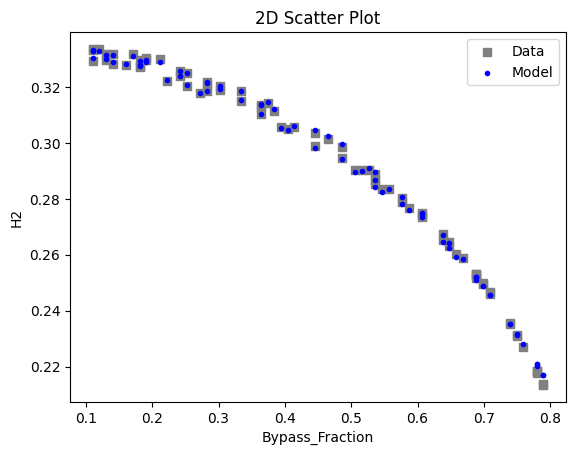

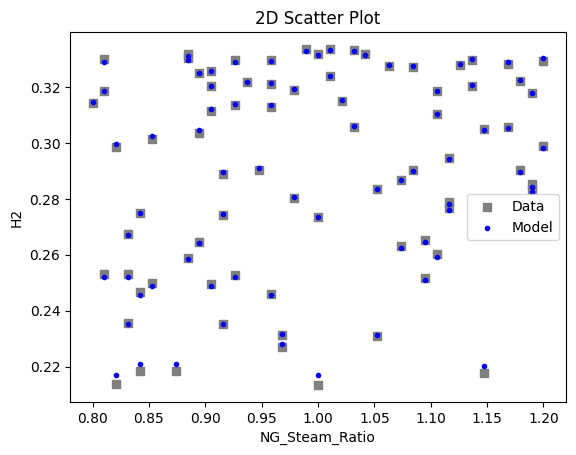

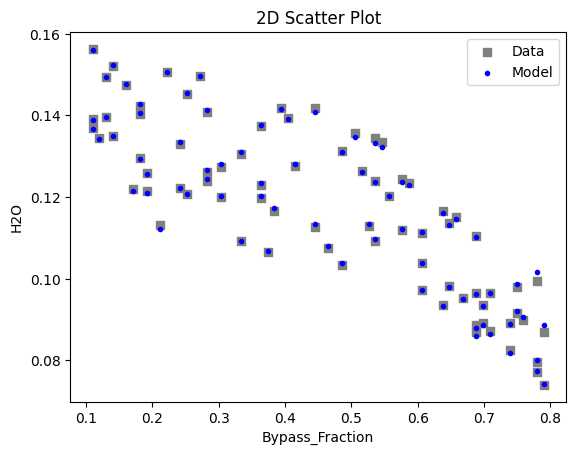

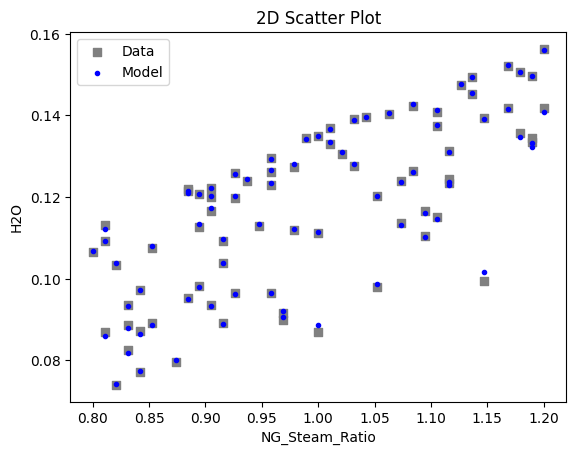

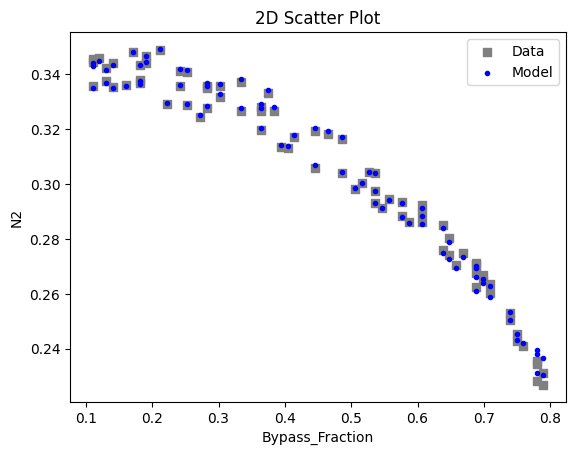

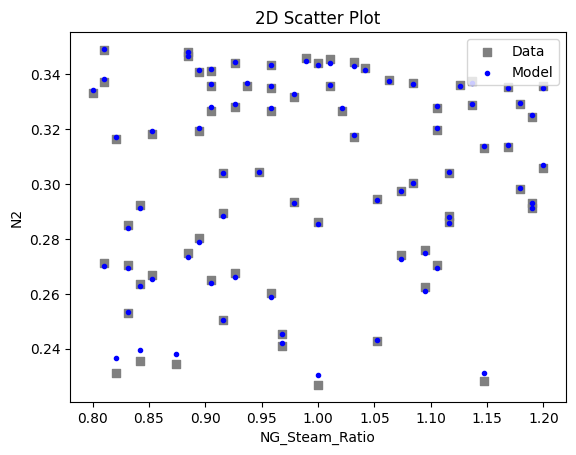

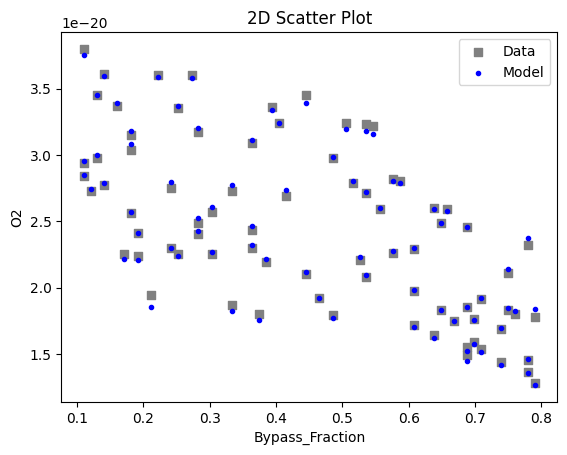

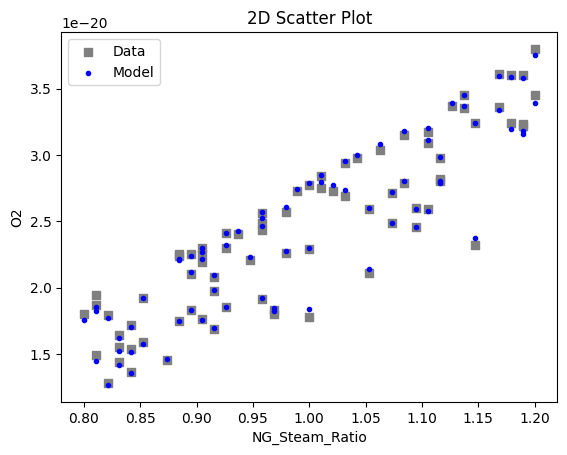

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


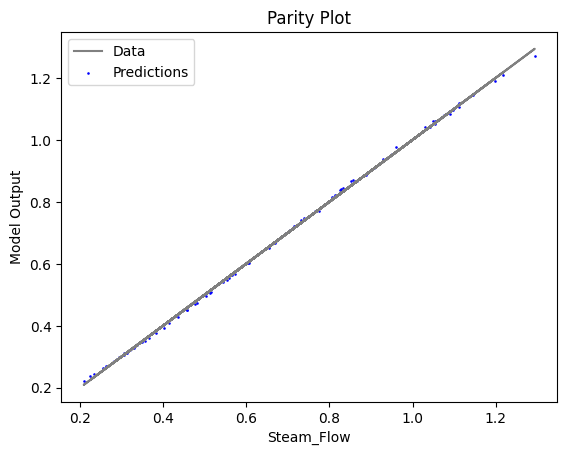

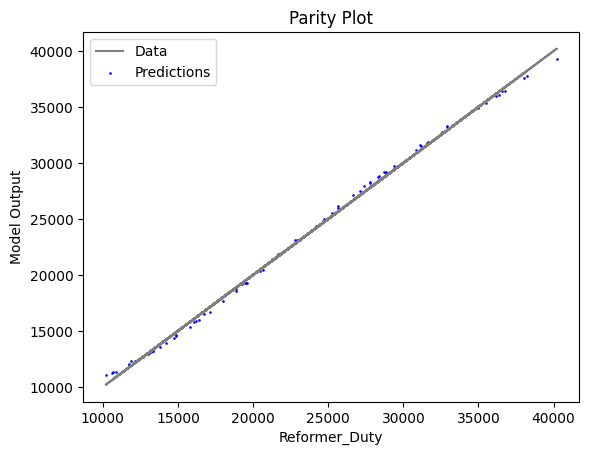

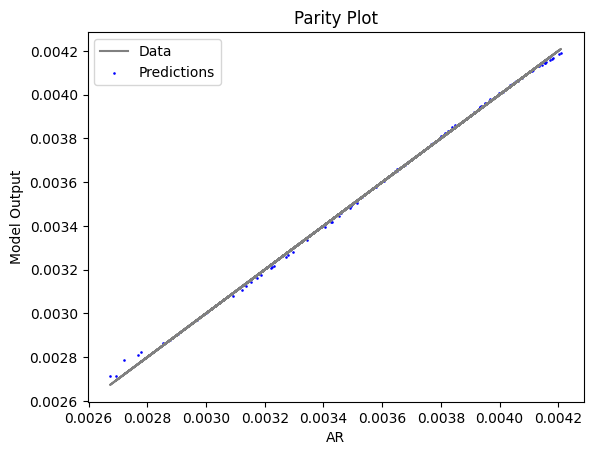

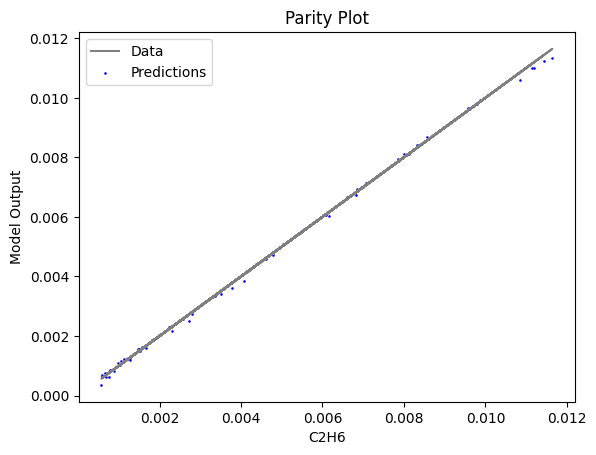

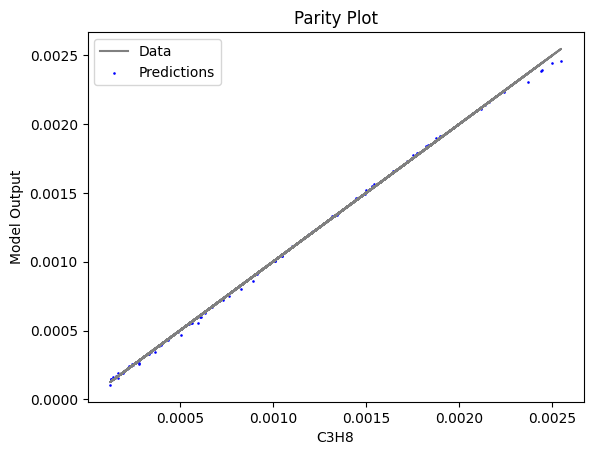

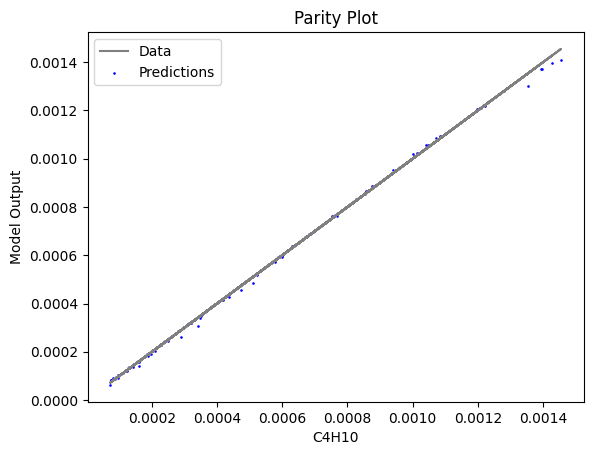

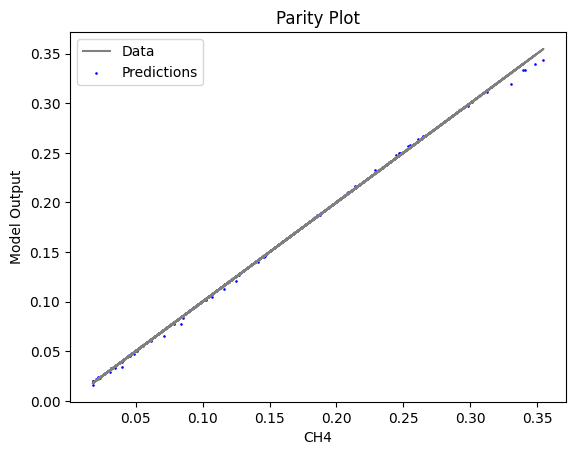

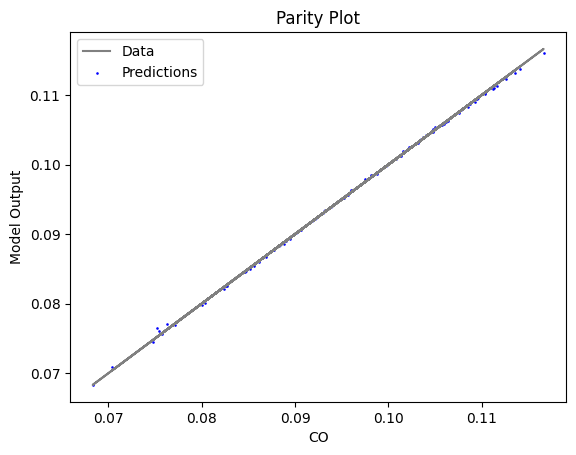

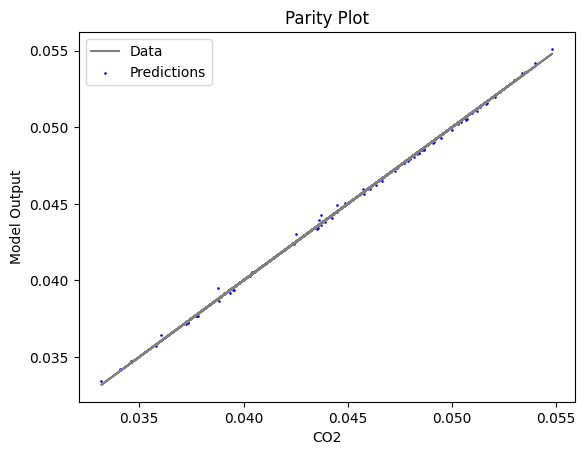

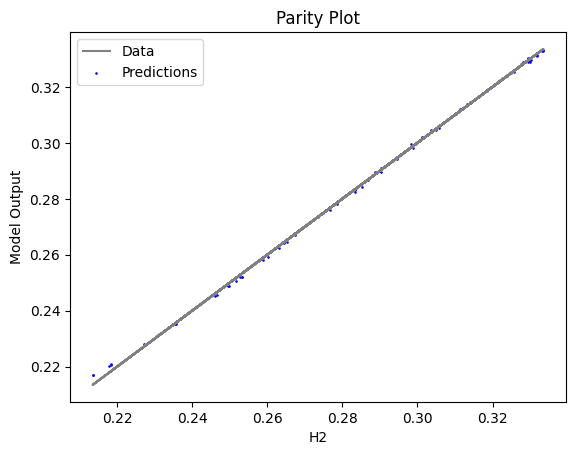

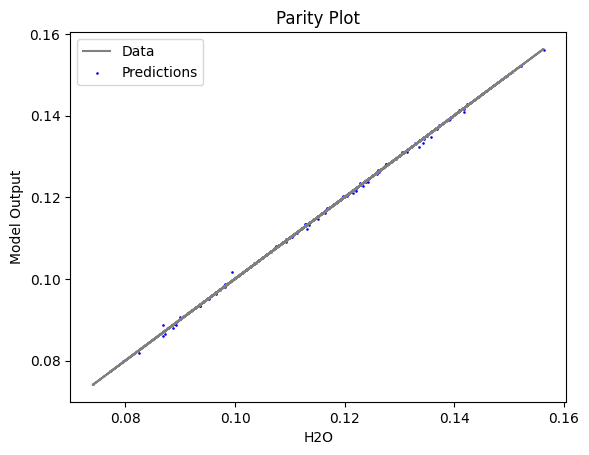

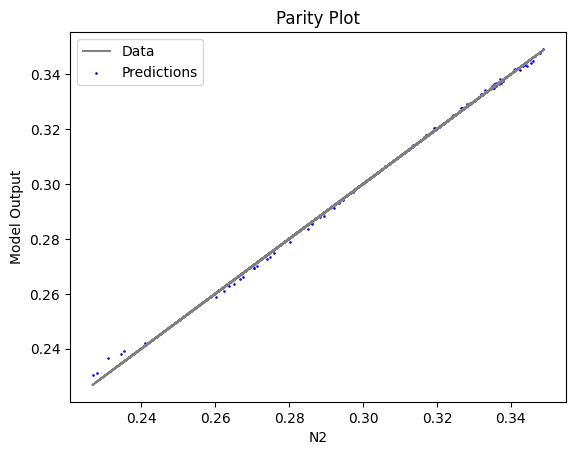

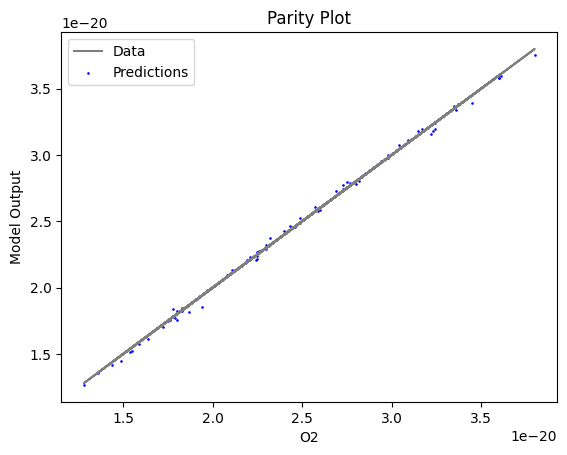

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


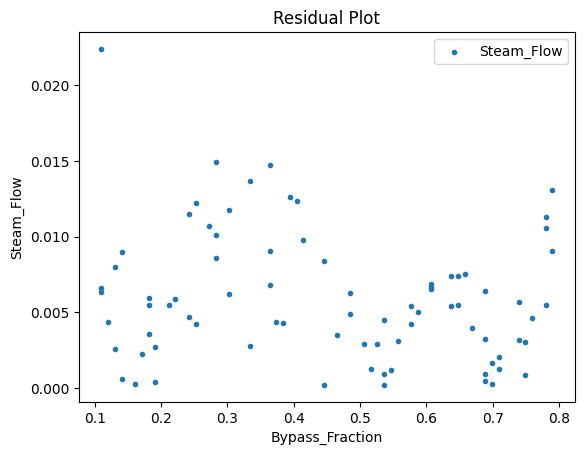

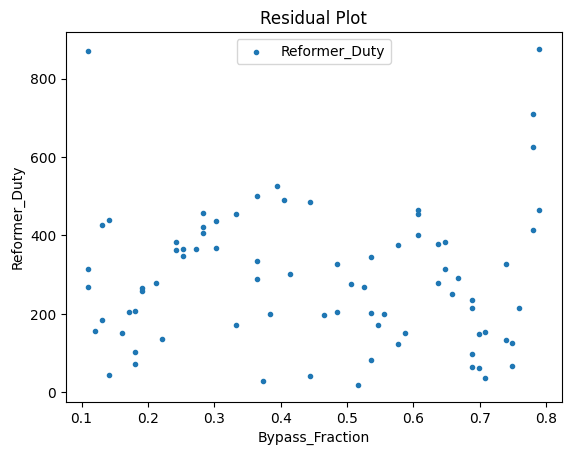

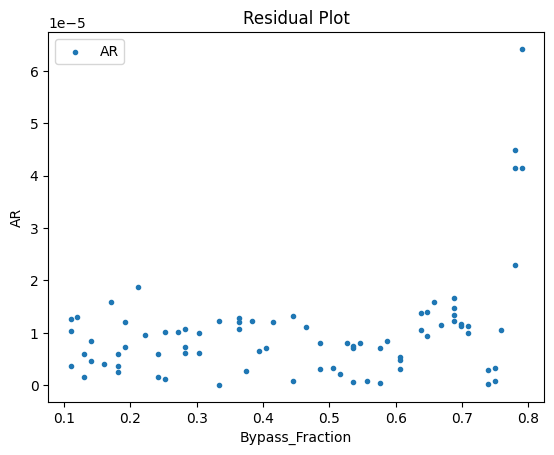

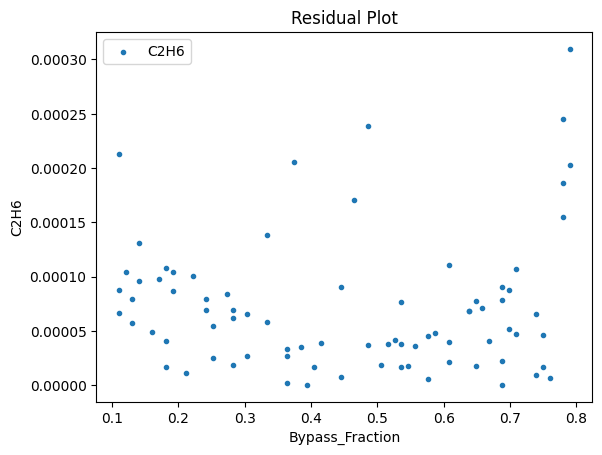

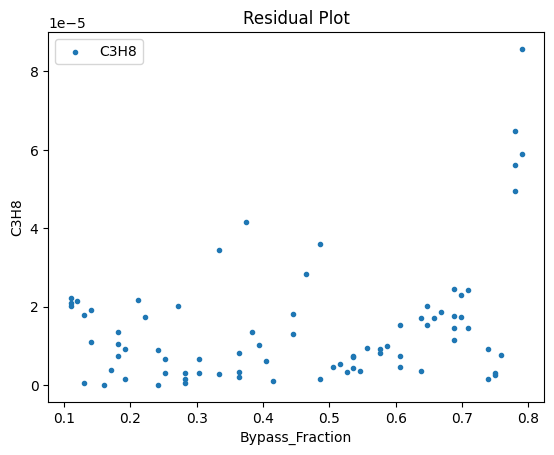

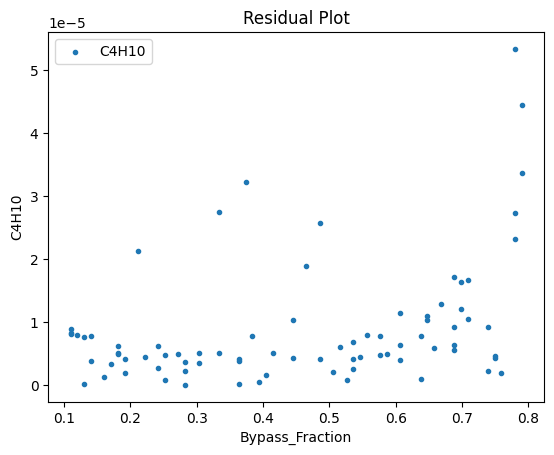

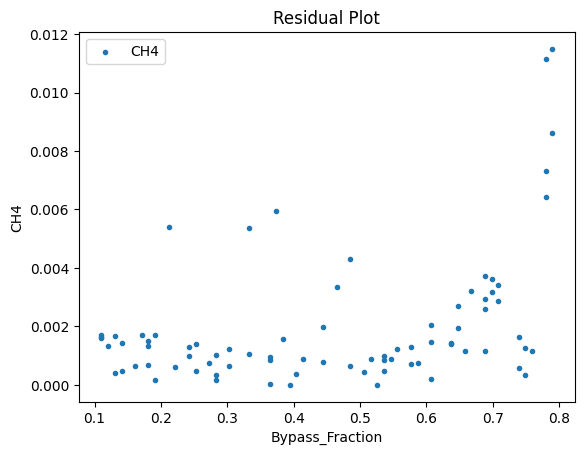

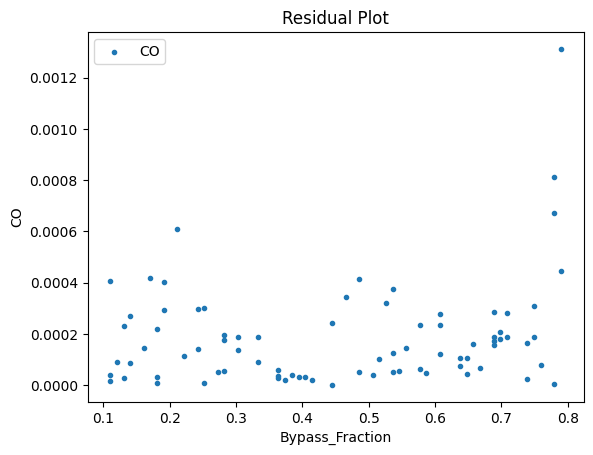

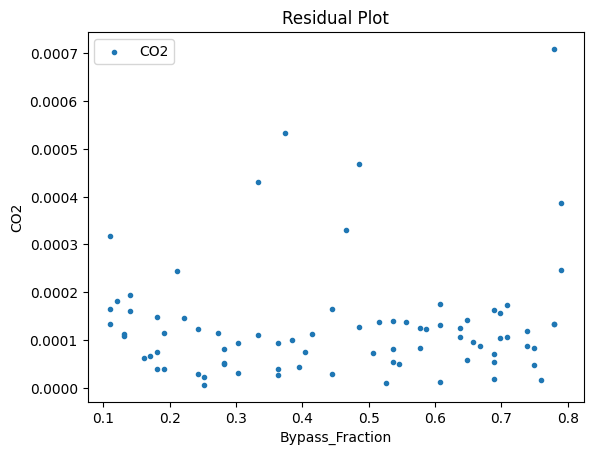

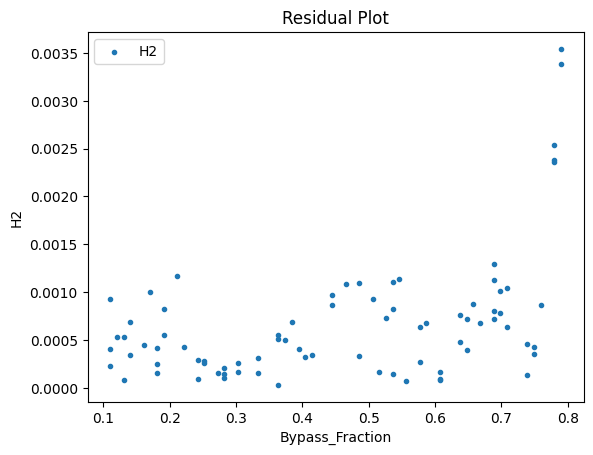

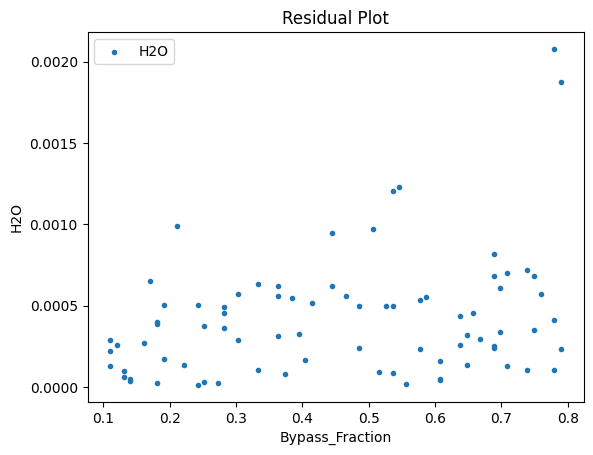

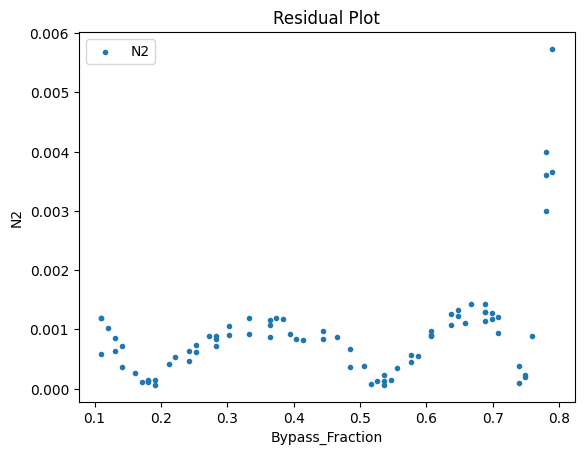

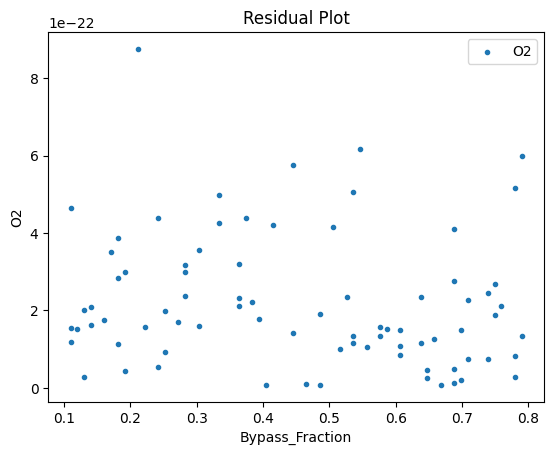

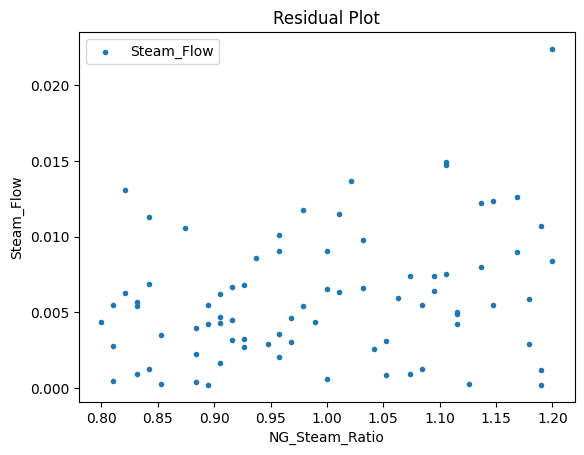

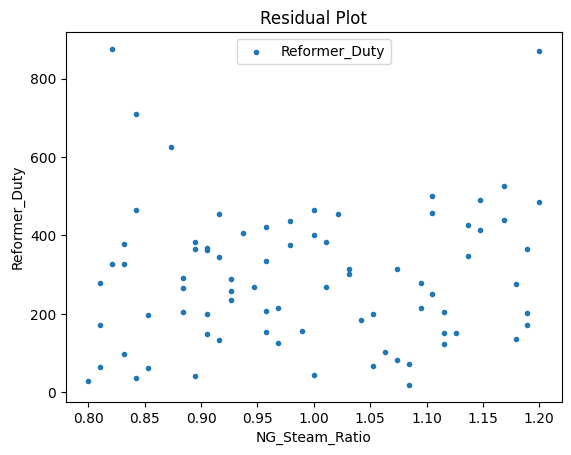

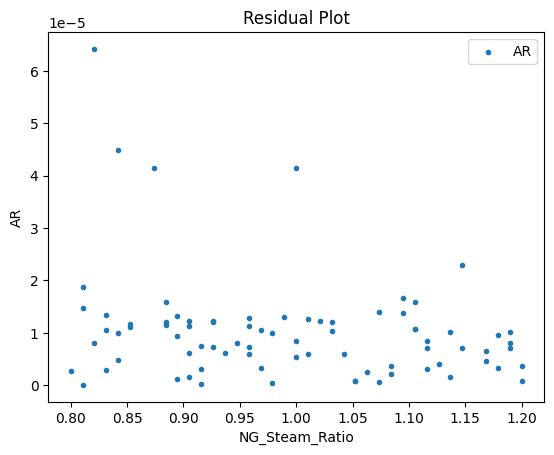

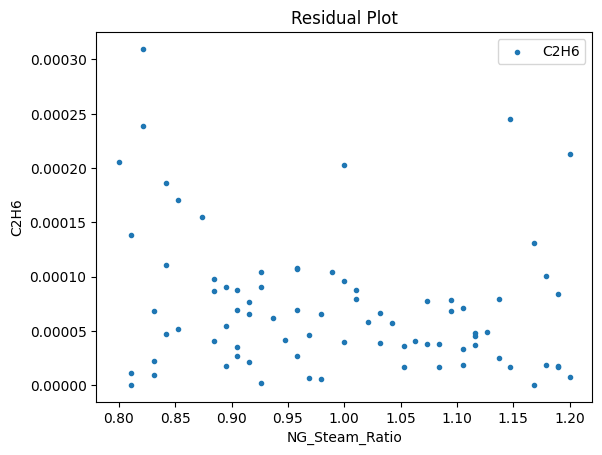

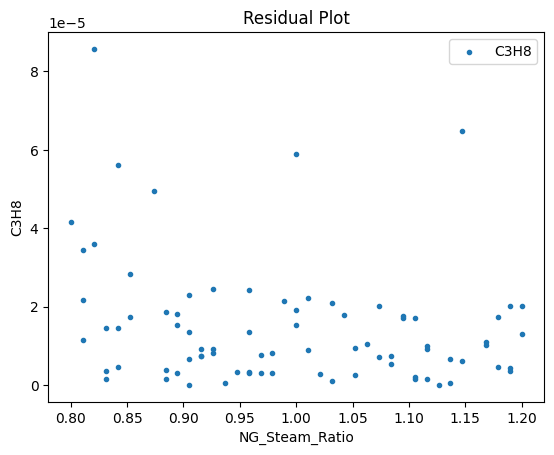

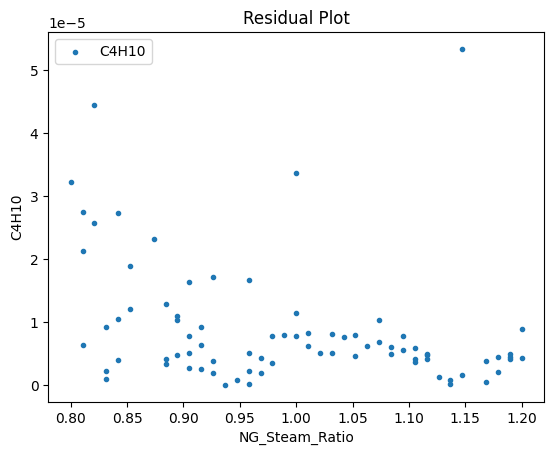

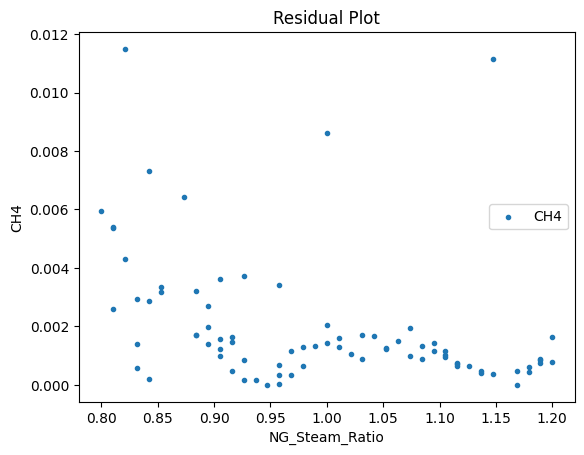

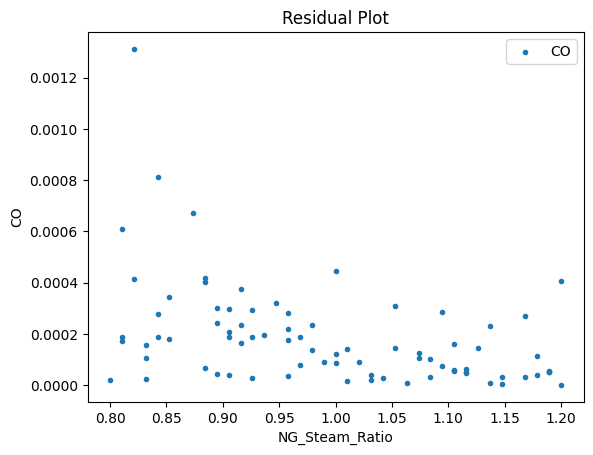

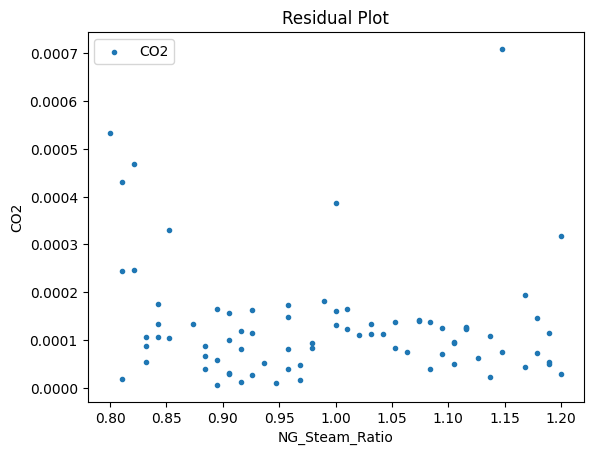

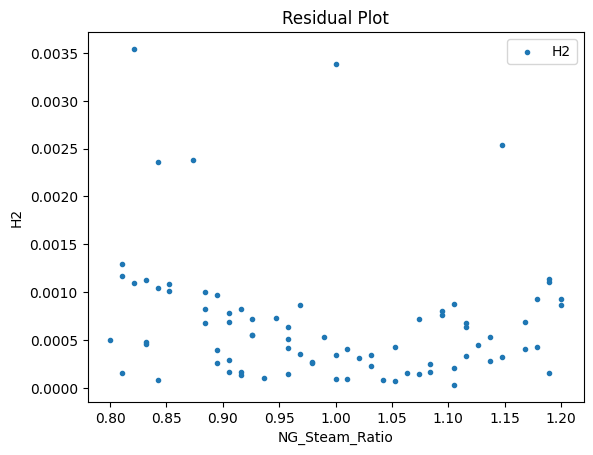

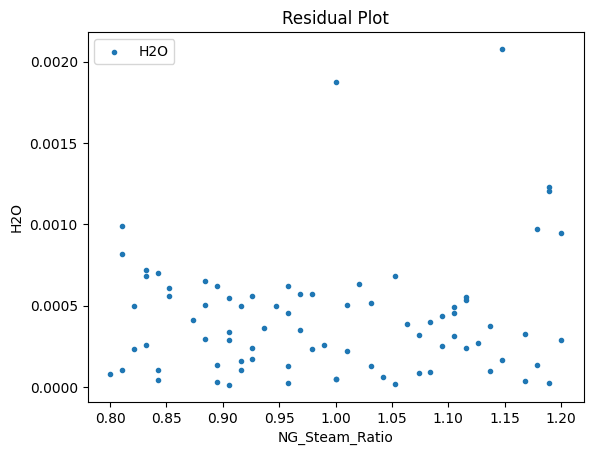

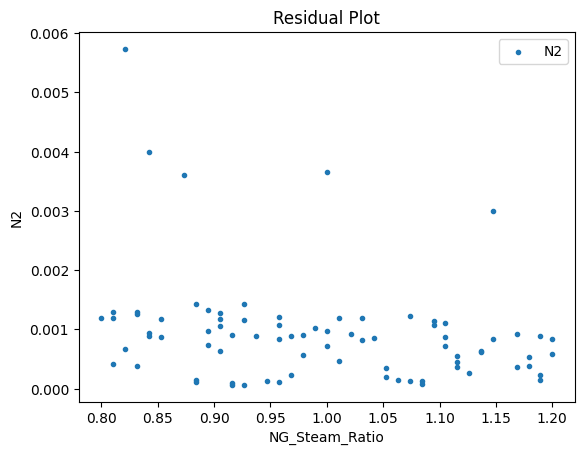

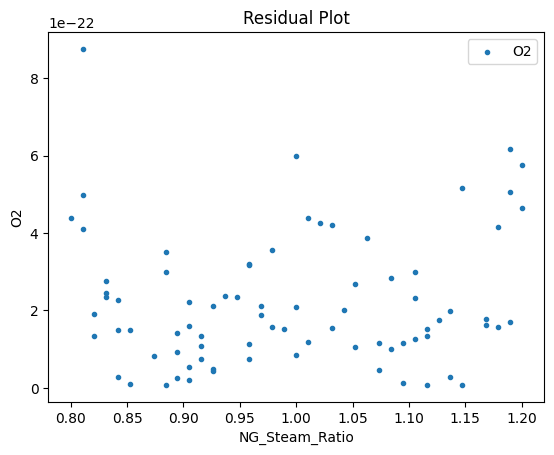

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(
    keras_surrogate, data_training, filename="keras_train_scatter2D.pdf"
)
surrogate_parity(keras_surrogate, data_training, filename="keras_train_parity.pdf")
surrogate_residual(keras_surrogate, data_training, filename="keras_train_residual.pdf")

## 3.4 Model Validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


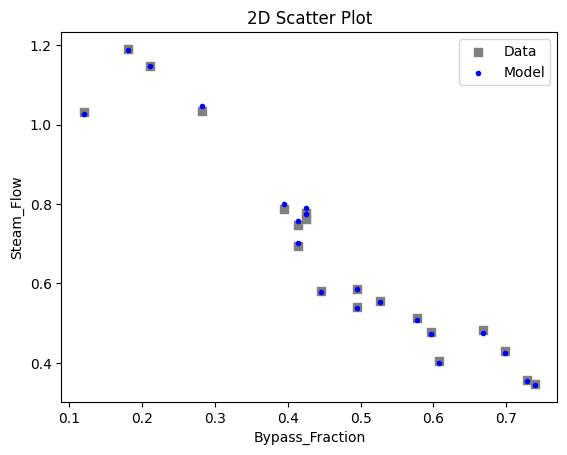

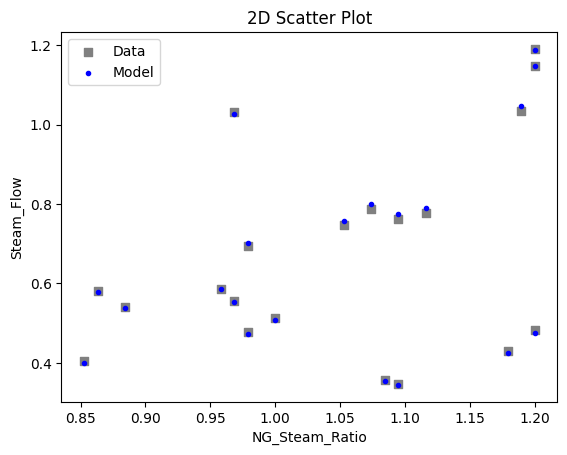

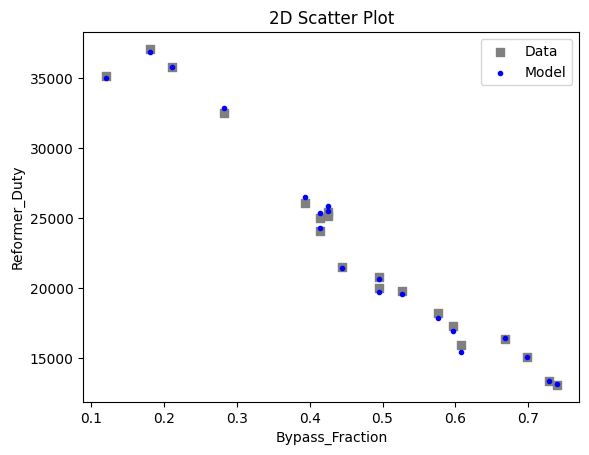

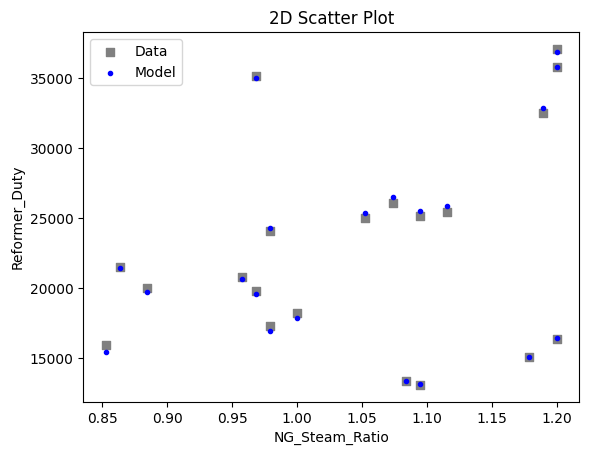

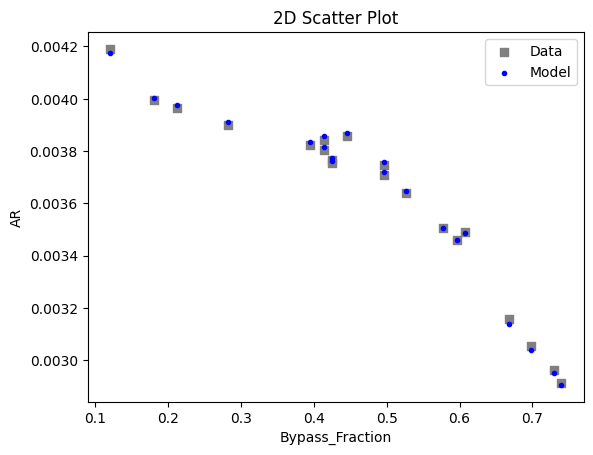

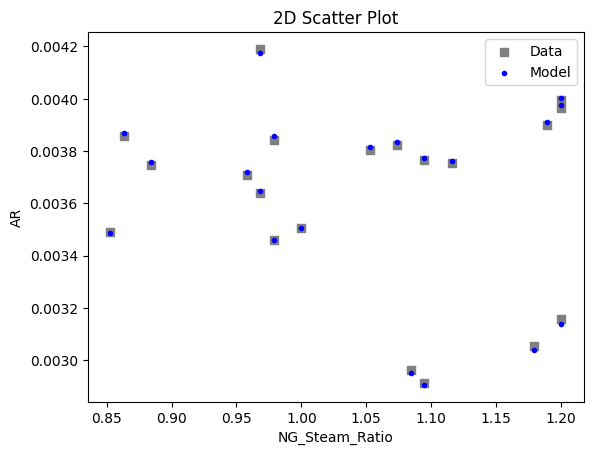

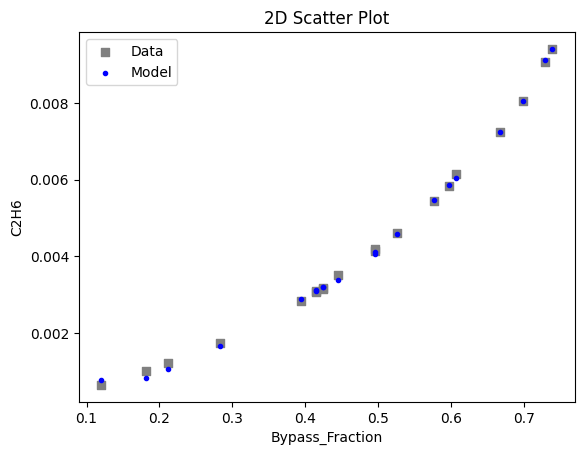

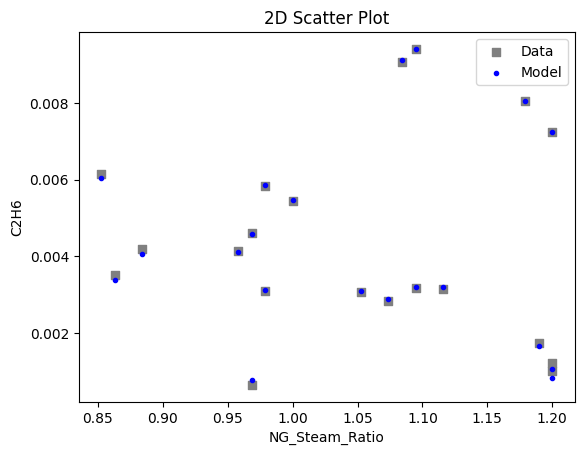

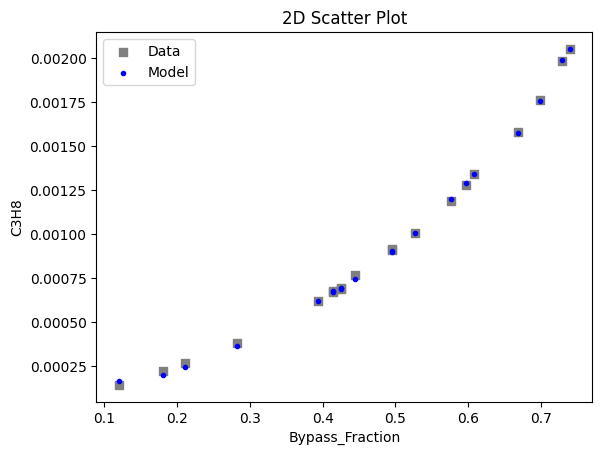

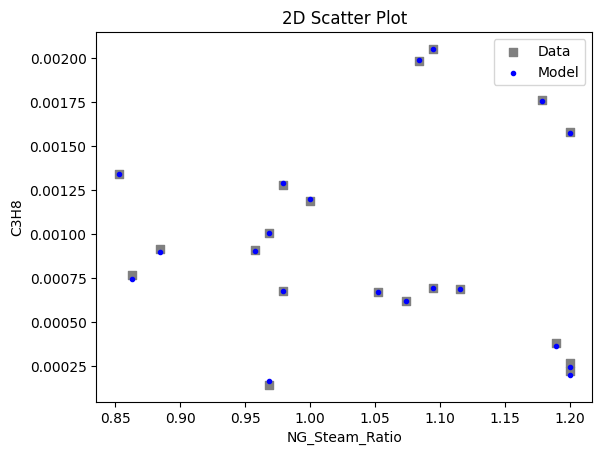

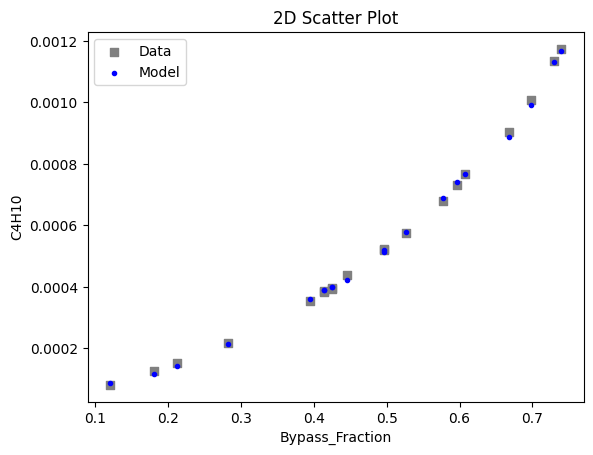

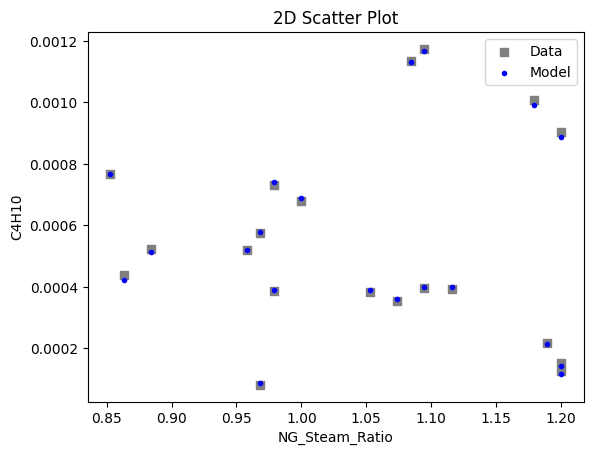

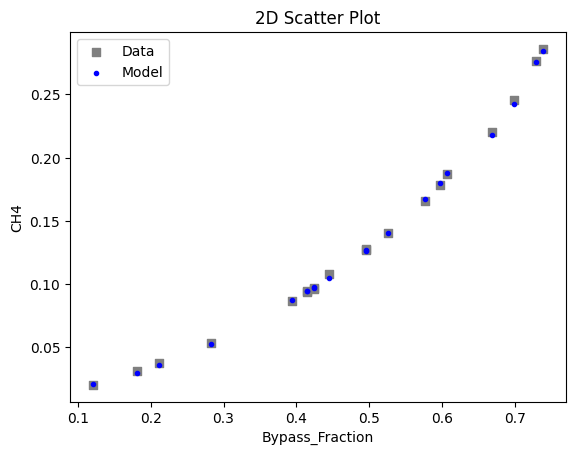

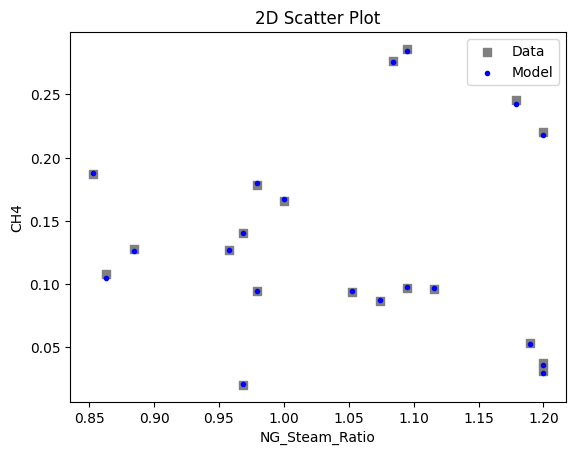

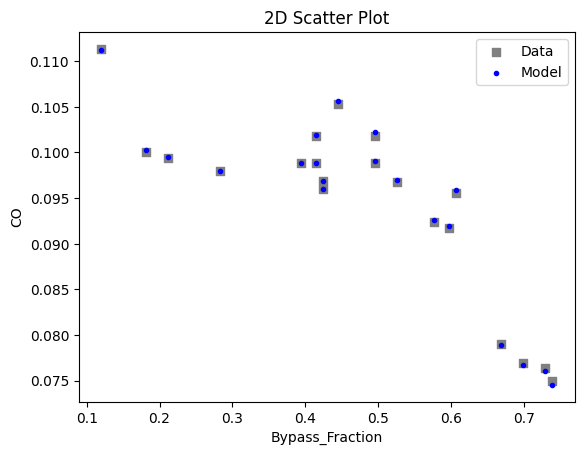

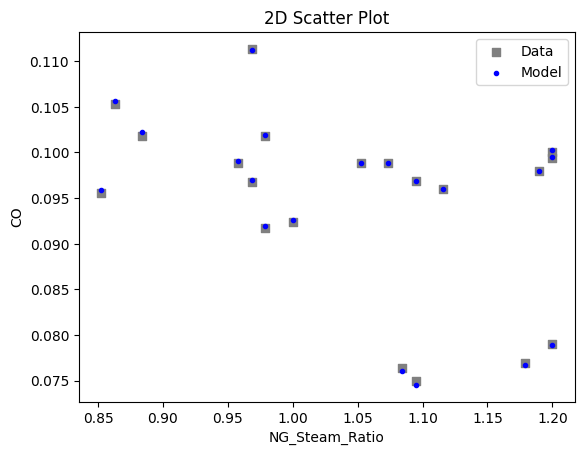

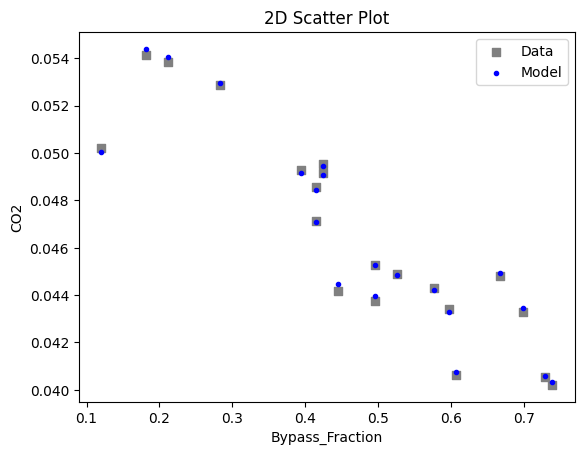

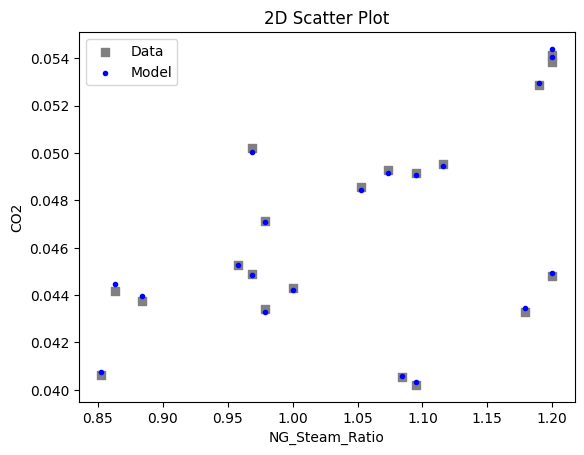

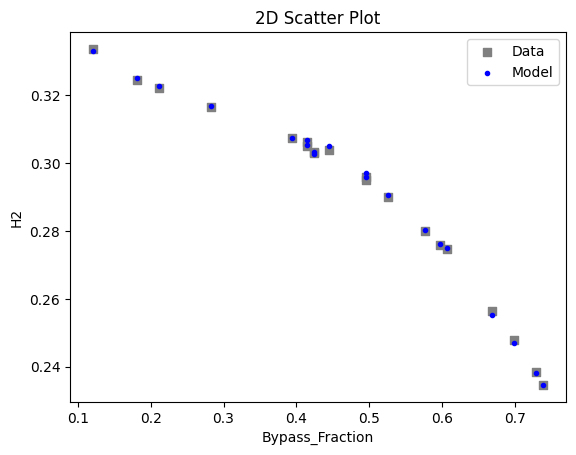

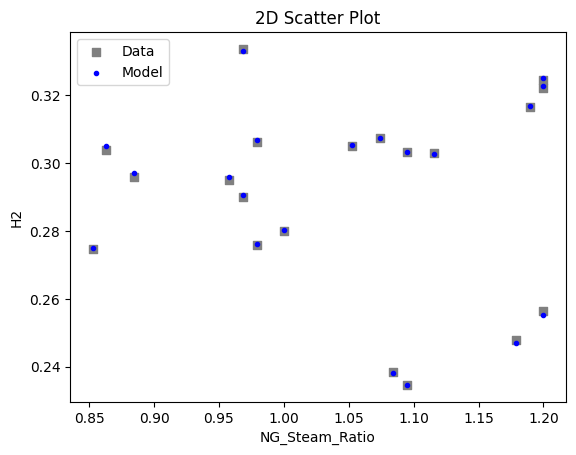

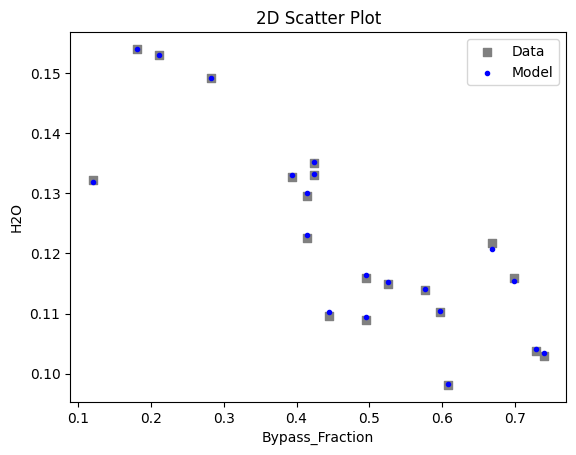

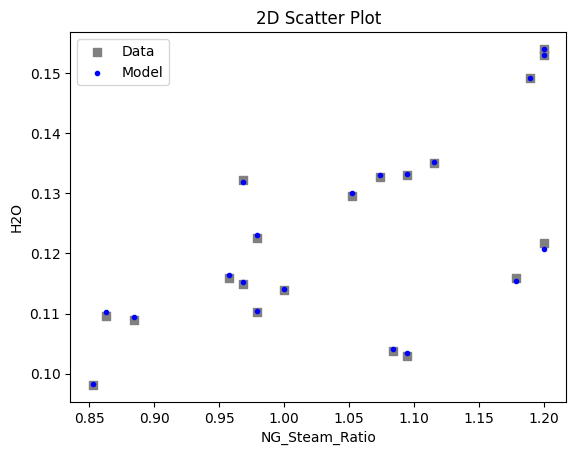

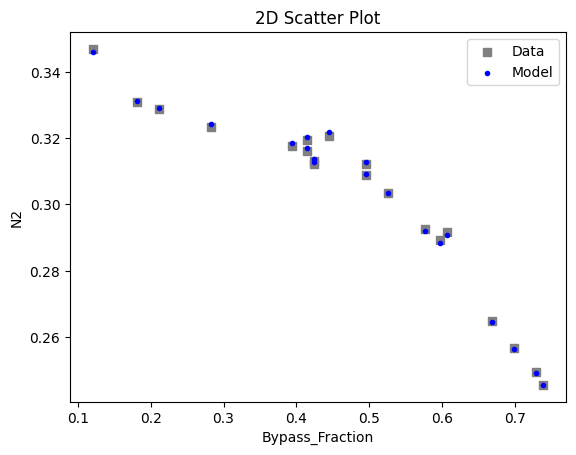

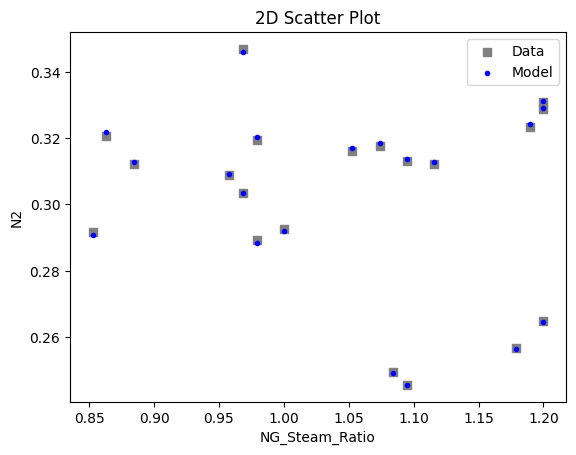

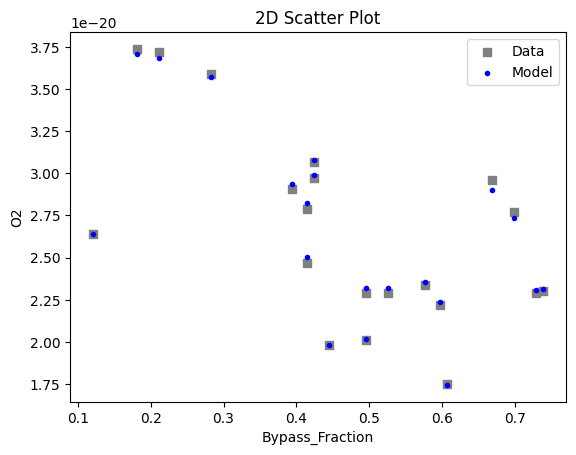

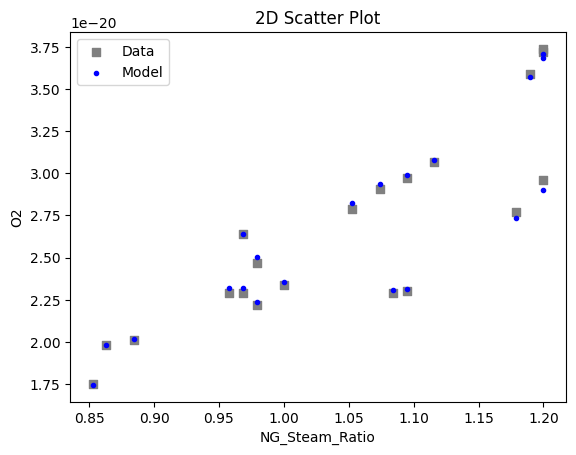

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


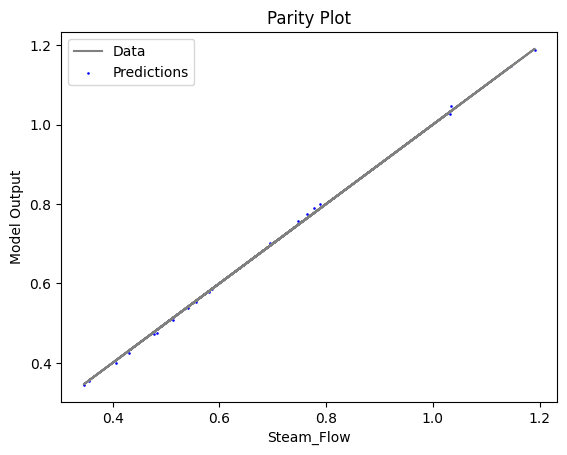

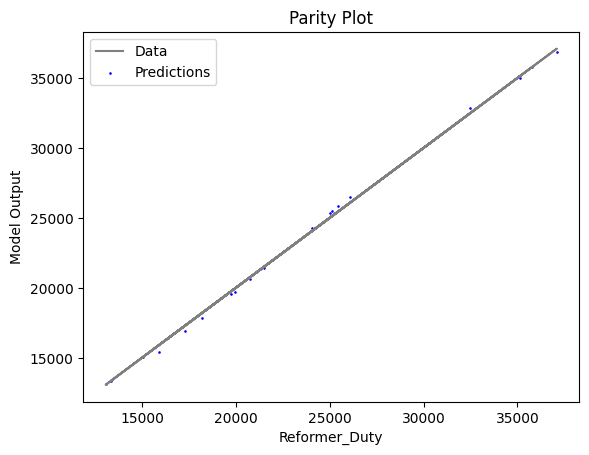

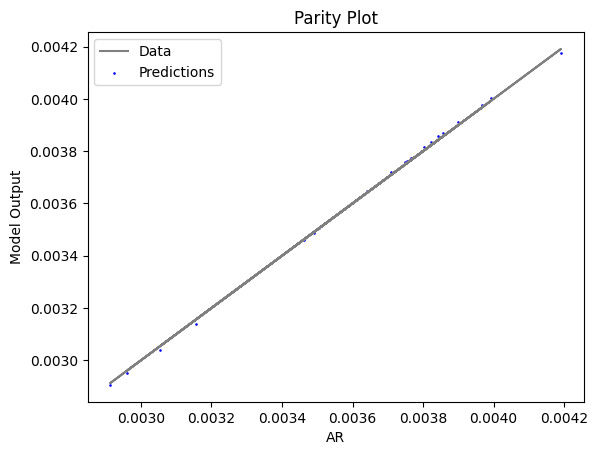

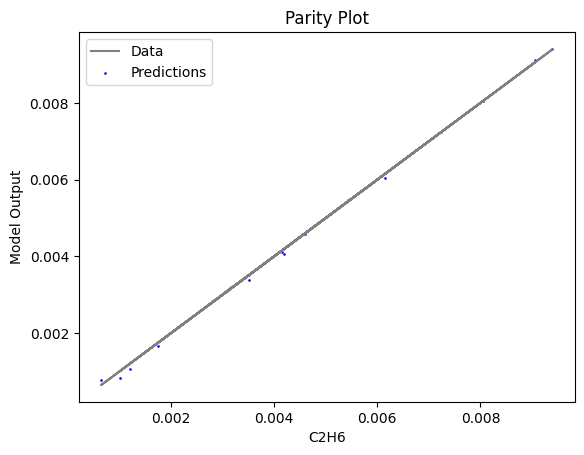

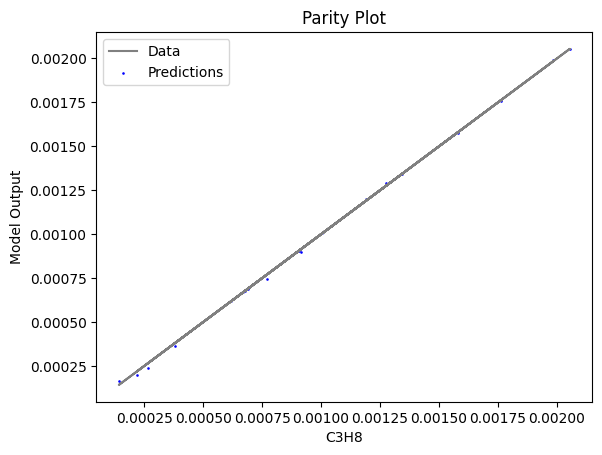

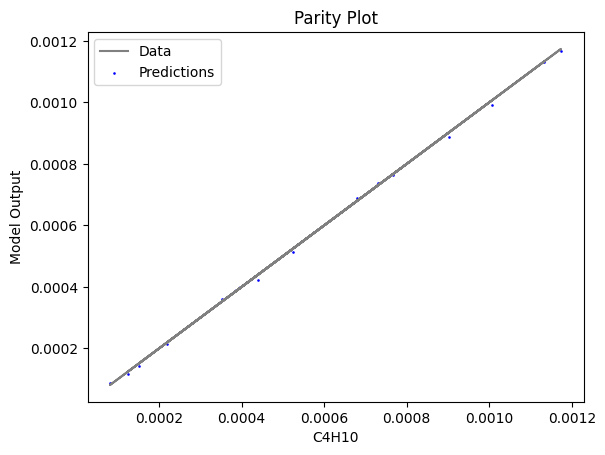

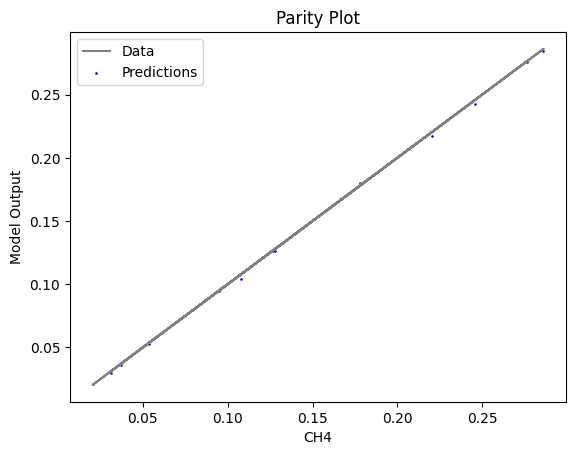

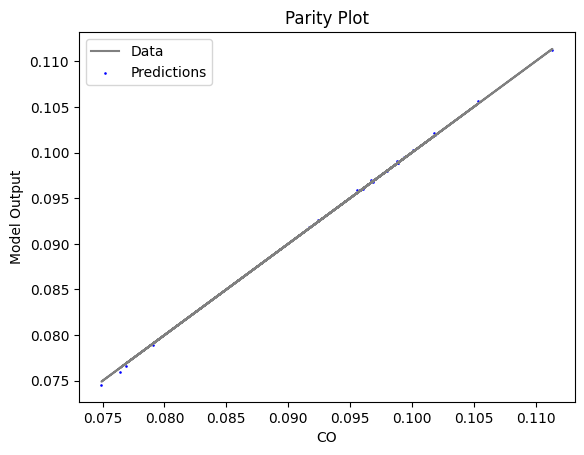

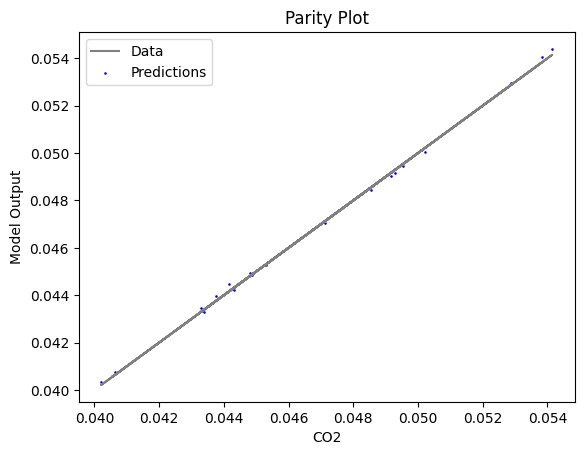

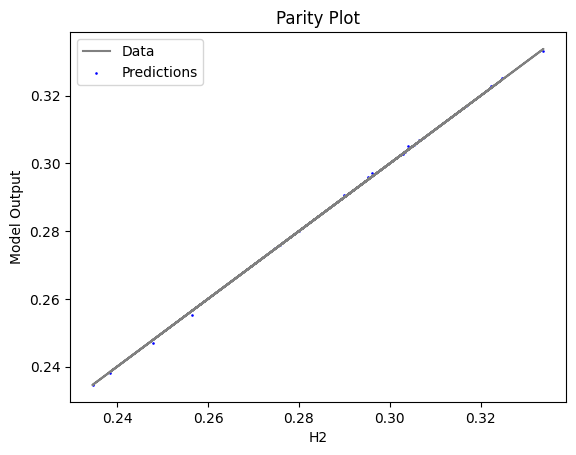

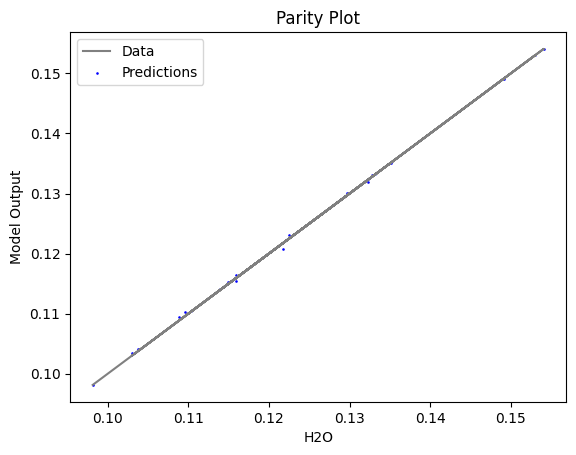

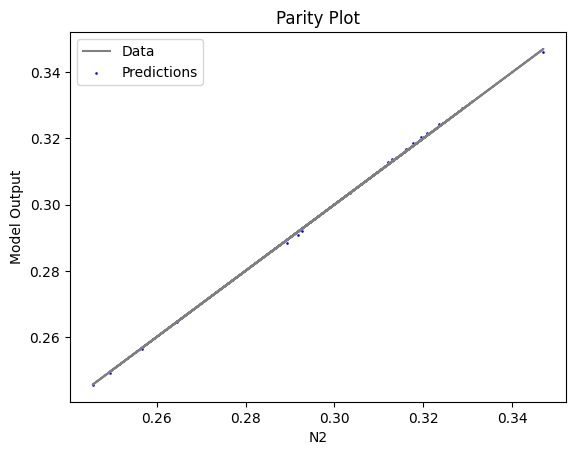

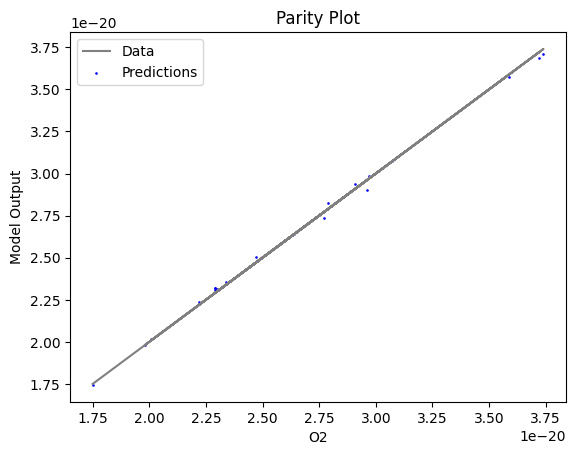

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


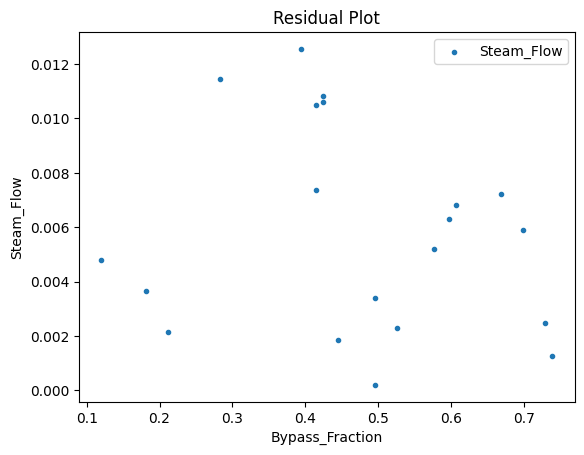

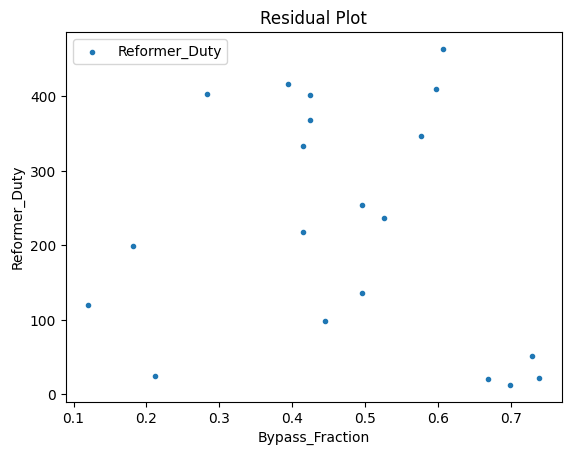

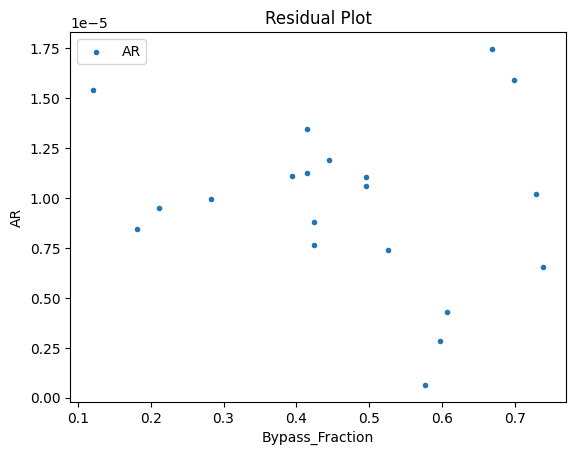

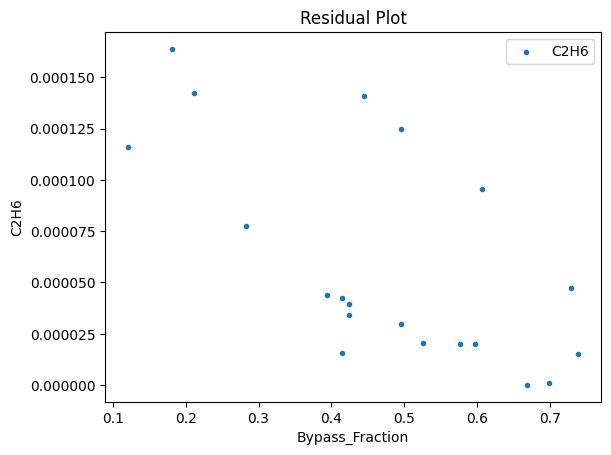

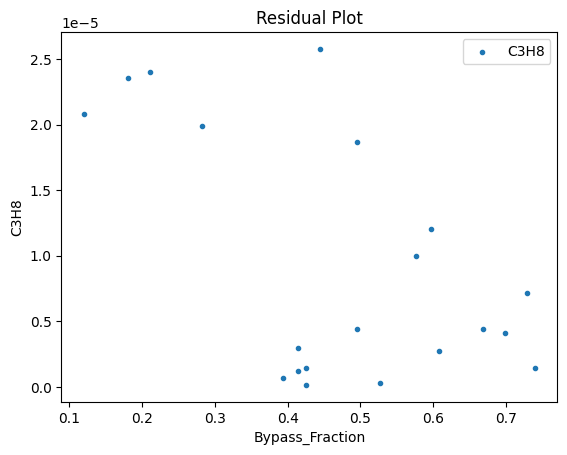

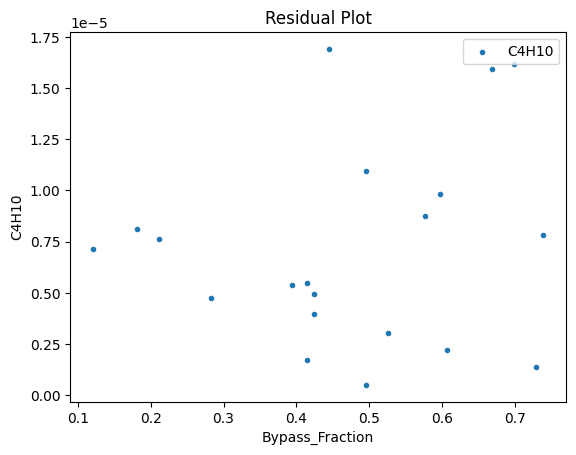

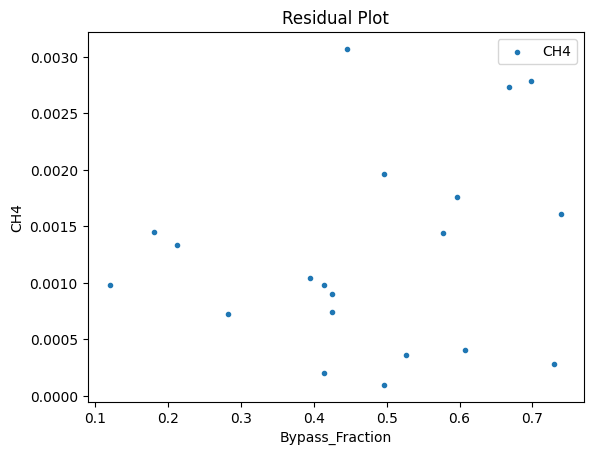

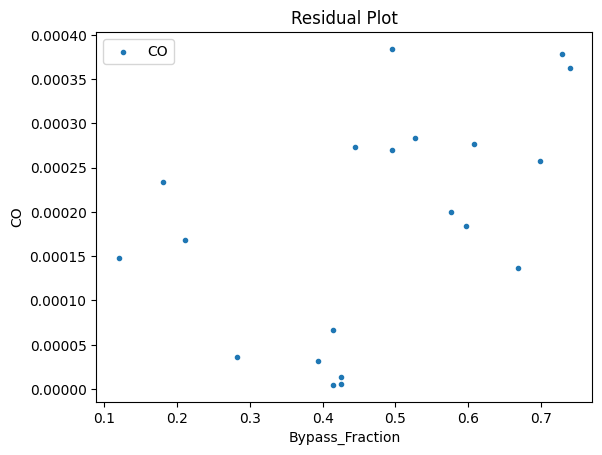

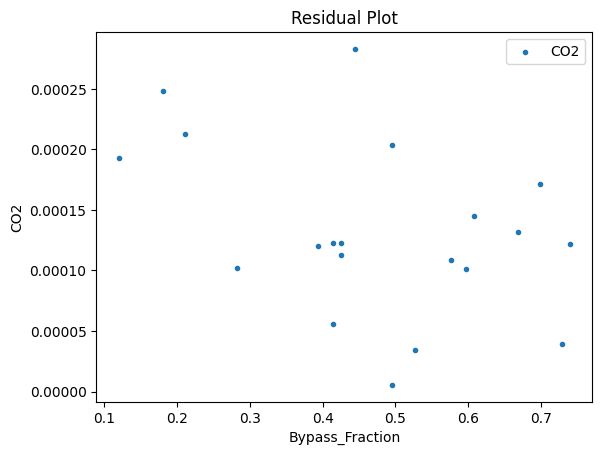

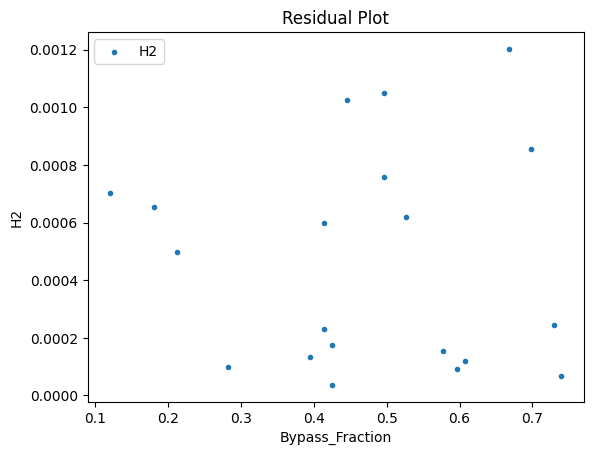

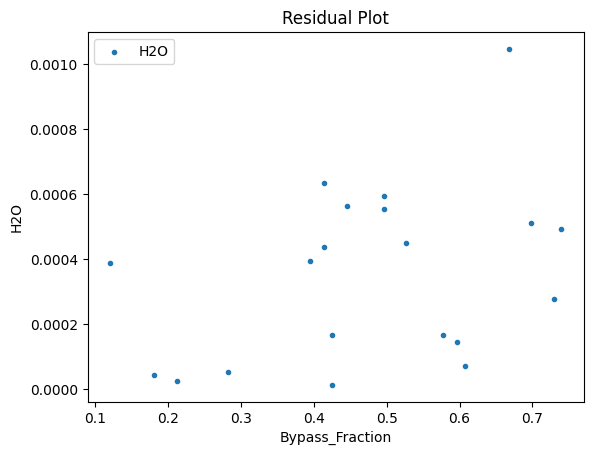

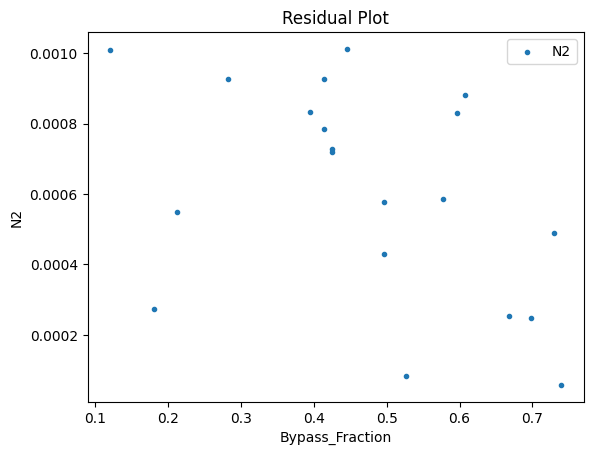

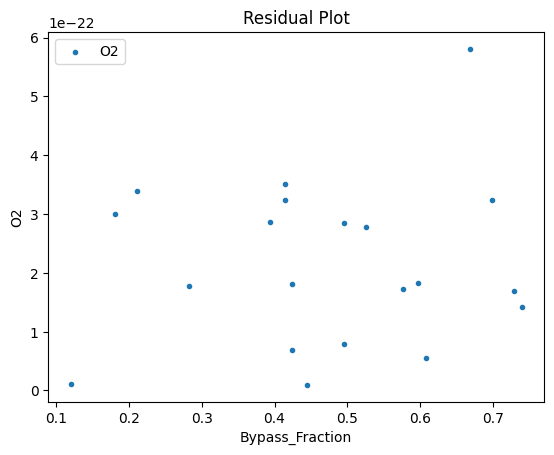

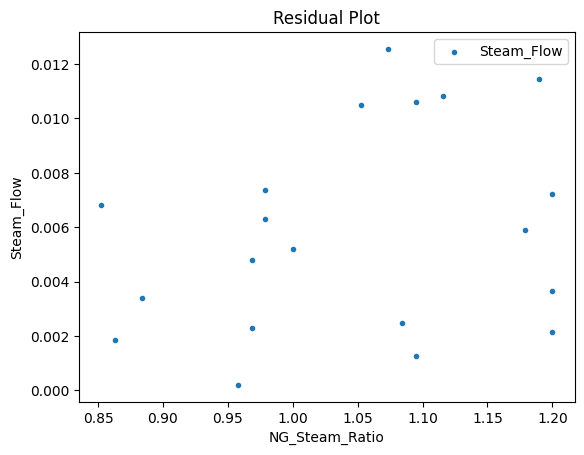

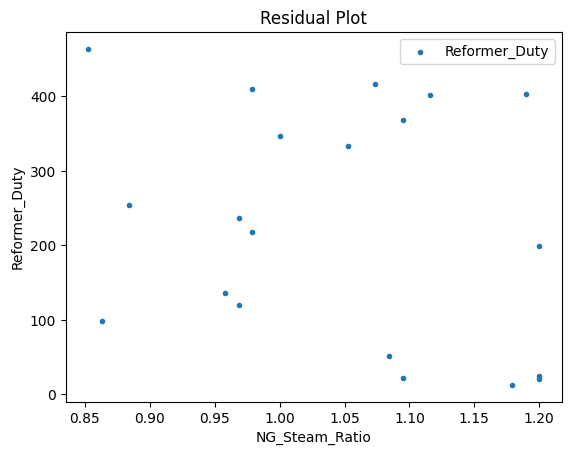

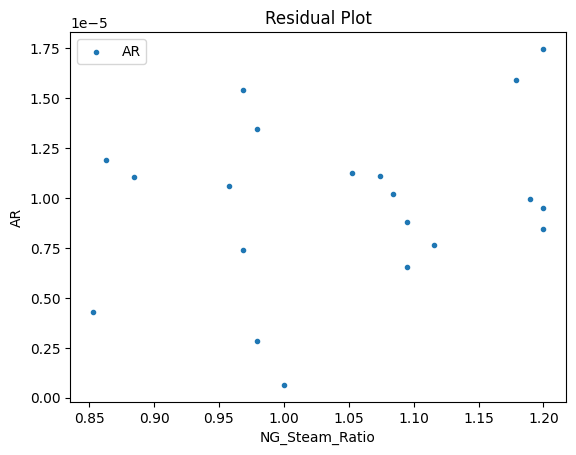

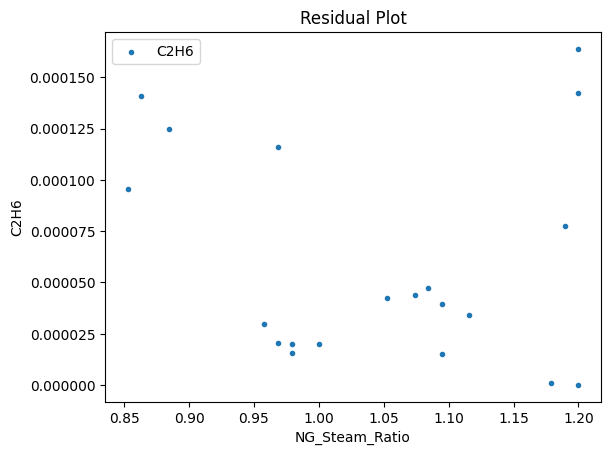

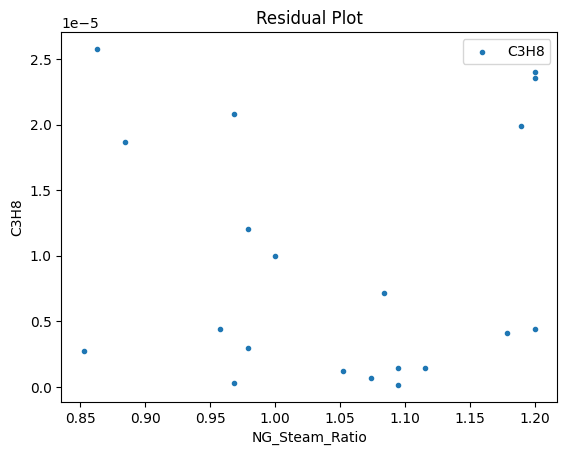

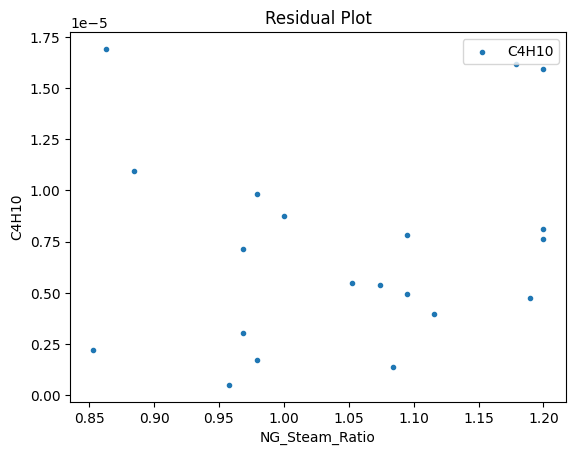

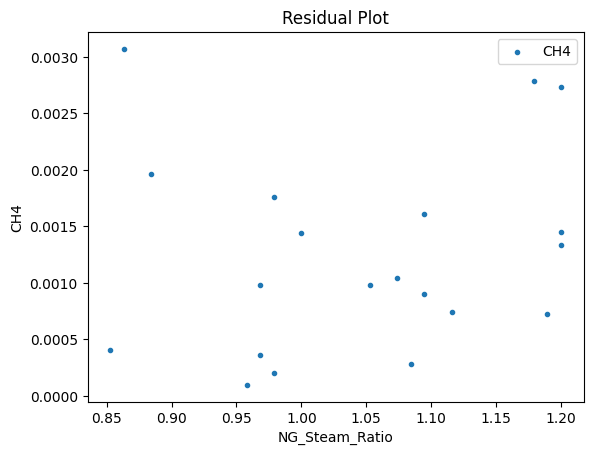

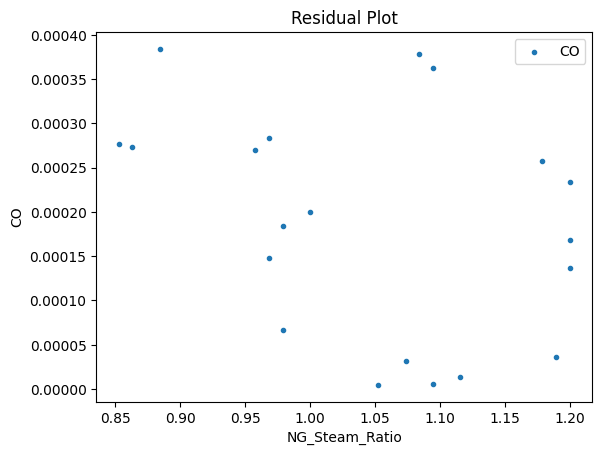

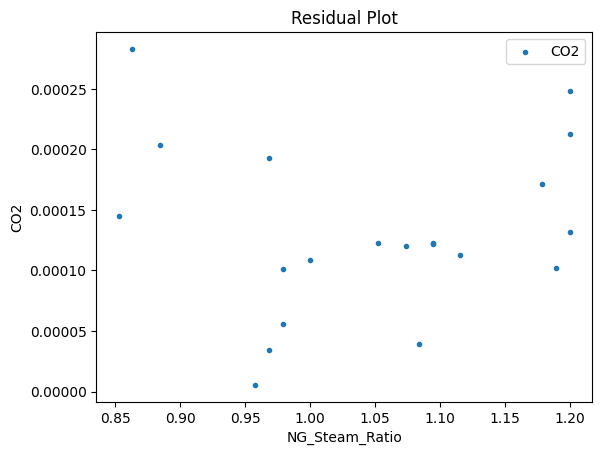

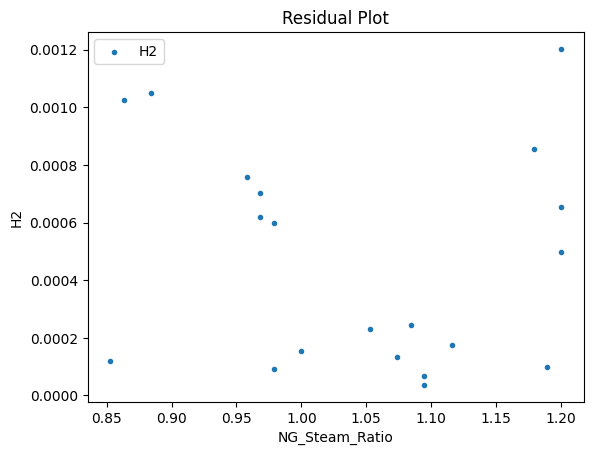

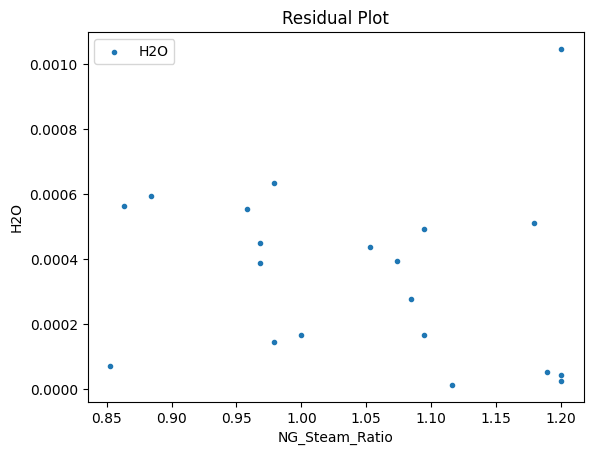

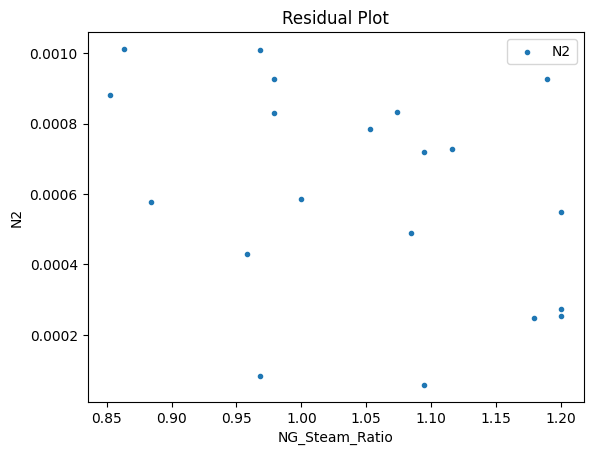

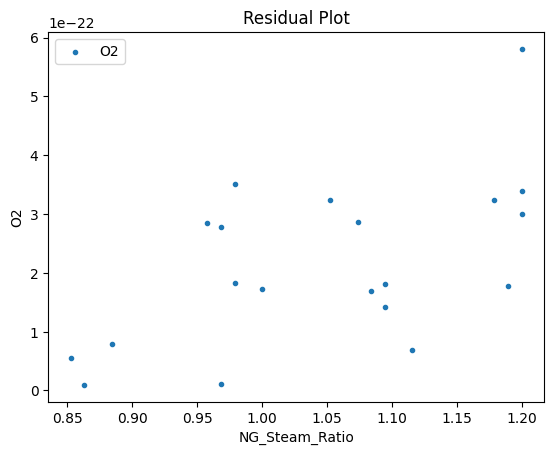

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [7]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(
    keras_surrogate, data_validation, filename="keras_val_scatter2D.pdf"
)
surrogate_parity(keras_surrogate, data_validation, filename="keras_val_parity.pdf")
surrogate_residual(keras_surrogate, data_validation, filename="keras_val_residual.pdf")

# 4. IDAES Flowsheet Integration

## 4.1 Build and Run IDAES Flowsheet

Next, we will build an IDAES flowsheet and import the surrogate model object. A single Keras neural network model accounts for all input and output variables, and the JSON model serialized earlier may be imported into a single SurrogateBlock() component.

In [8]:
# create the IDAES model and flowsheet
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

# create flowsheet input variables
m.fs.bypass_frac = Var(
    initialize=0.80, bounds=[0.1, 0.8], doc="natural gas bypass fraction"
)
m.fs.ng_steam_ratio = Var(
    initialize=0.80, bounds=[0.8, 1.2], doc="natural gas to steam ratio"
)

# create flowsheet output variables
m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
m.fs.AR = Var(initialize=0, doc="AR fraction")
m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
m.fs.CO = Var(initialize=0, doc="CO fraction")
m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
m.fs.H2 = Var(initialize=0, doc="H2 fraction")
m.fs.H2O = Var(initialize=0, doc="H2O fraction")
m.fs.N2 = Var(initialize=0, doc="N2 fraction")
m.fs.O2 = Var(initialize=0, doc="O2 fraction")

# create input and output variable object lists for flowsheet
inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
outputs = [
    m.fs.steam_flowrate,
    m.fs.reformer_duty,
    m.fs.AR,
    m.fs.C2H6,
    m.fs.C4H10,
    m.fs.C3H8,
    m.fs.CH4,
    m.fs.CO,
    m.fs.CO2,
    m.fs.H2,
    m.fs.H2O,
    m.fs.N2,
    m.fs.O2,
]

# create the Pyomo/IDAES block that corresponds to the surrogate
# Keras
keras_surrogate = KerasSurrogate.load_from_folder(
    keras_folder_name="keras_surrogate", keras_model_name="keras_model"
)
m.fs.surrogate = SurrogateBlock()
m.fs.surrogate.build_model(
    keras_surrogate,
    formulation=KerasSurrogate.Formulation.FULL_SPACE,
    input_vars=inputs,
    output_vars=outputs,
)

# fix input values and solve flowsheet
m.fs.bypass_frac.fix(0.5)
m.fs.ng_steam_ratio.fix(1)

solver = SolverFactory("ipopt")
results = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Let's print some model results:

In [9]:
print("Steam flowrate = ", value(m.fs.steam_flowrate))
print("Reformer duty = ", value(m.fs.reformer_duty))
print("Mole Fraction Ar = ", value(m.fs.AR))
print("Mole Fraction C2H6 = ", value(m.fs.C2H6))
print("Mole Fraction C3H8 = ", value(m.fs.C3H8))
print("Mole Fraction C4H10 = ", value(m.fs.C4H10))
print("Mole Fraction CH4 = ", value(m.fs.CH4))
print("Mole Fraction CO = ", value(m.fs.CO))
print("Mole Fraction CO2 = ", value(m.fs.CO2))
print("Mole Fraction H2 = ", value(m.fs.H2))
print("Mole Fraction H2O = ", value(m.fs.H2O))
print("Mole Fraction N2 = ", value(m.fs.N2))
print("Mole Fraction O2 = ", value(m.fs.O2))

Steam flowrate =  0.6068368589186967
Reformer duty =  20991.593615005655
Mole Fraction Ar =  0.0036876627716784078
Mole Fraction C2H6 =  0.0041922326063124704
Mole Fraction C3H8 =  0.000527814905073567
Mole Fraction C4H10 =  0.0009169578471303844
Mole Fraction CH4 =  0.12842550728190893
Mole Fraction CO =  0.09715611233240133
Mole Fraction CO2 =  0.04595020144165076
Mole Fraction H2 =  0.2943636734533869
Mole Fraction H2O =  0.1200063881622875
Mole Fraction N2 =  0.3067149530501456
Mole Fraction O2 =  2.4843636525024052e-20


## 4.2 Optimizing the Autothermal Reformer
Extending this example, we will unfix the input variables and optimize hydrogen production. We will restrict nitrogen below 34 mol% of the product stream and leave all other variables unfixed.

Above, variable values are called in reference to actual objects names; however, as shown below this may be done much more compactly by calling the list objects we created earlier.

In [10]:
# unfix input values and add the objective/constraint to the model
m.fs.bypass_frac.unfix()
m.fs.ng_steam_ratio.unfix()
m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

# solve the model
tmr = TicTocTimer()
status = solver.solve(m, tee=True)
solve_time = tmr.toc("solve")

# print and check results
assert abs(value(m.fs.H2) - 0.33) <= 0.01
assert value(m.fs.N2 <= 0.4 + 1e-8)
print("Model status: ", status)
print("Solve time: ", solve_time)
for var in inputs:
    print(var.name, ": ", value(var))
for var in outputs:
    print(var.name, ": ", value(var))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

[+   0.03] solve
Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 232
  Number of variables: 233
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.01901984214782715
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solve time:  0.027978026002529077
fs.bypass_frac :  0.10000020212075882
fs.ng_steam_ratio :  1.100676931942783
fs.steam_flowrate :  1.1878835613476406
fs.reformer_duty :  38002.3828518229
fs.AR :  0.004116895599526309
fs.C2H6 :  0.0004913978369500205
fs.C4H10 :  0.00012539103921606313
fs.C3H8 :  6.923814505429928e-05
fs.CH4 :  0.017457976165817648
fs.CO :  0.10608503398940847
fs.CO2 :  0.05310177709899404
fs.H2 :  0.3325004557943324
fs.H2O :  0.14644614887662047
fs.N2 :  0.3400000016914794
fs.O2 :  3.2942822113301266e-20
